## This Notebook is tasked with learning the kernel from some pinhole data. 
#### We do it in two stages. First we apply an affine transform model to get the kernel in the right location. Then we make regions of the kernel trainable and do further training. 

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd

from forward.fourier.kernel_creator import *
import scipy.ndimage
# from skimage.transform import rotate
from scipy.ndimage import rotate

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2
device = 'cuda:3'

desired_range = [735,865]
desired_channels = 80


4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
def WienerDeconvolution(final, kernel, lamb = 0.001):
    
    nc = kernel.shape[-1]
    padder = [[0,0]]*(len(kernel.shape) -1) + [[nc//2,nc//2]]
    
    # kernel = np.fft.fftshift(kernel)

    
    kernelpad = np.pad(kernel,padder)
    finalpad = np.pad(final,padder)
    
    kernel_fft = np.fft.fft(kernelpad,axis=-1)
    final_fft = np.fft.fft(finalpad,axis=-1)

    original_fft=(np.conj(kernel_fft)*final_fft)/ (np.square(np.abs(kernel_fft))+ lamb)


    original = np.abs(np.fft.ifftshift(np.fft.ifft(original_fft,axis=-1),axes=-1))

    original = original[...,nc//2:-(nc//2)]

    return original

First load pinhole cubes with and without grating

(2448, 150) (1, 150)


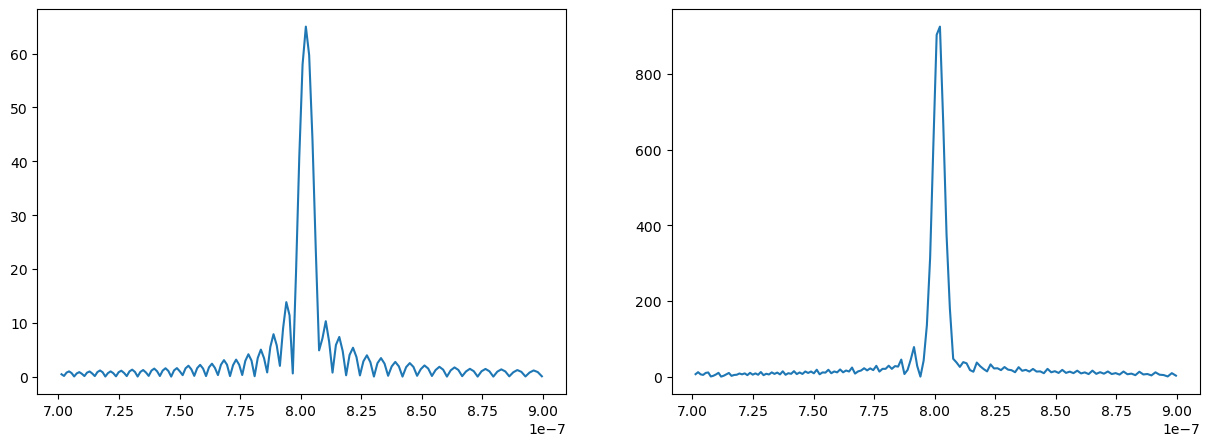

In [117]:
anadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230925_1grating_pinhole_analysis_exptime_3500_us/'

cube, wavls, freqs = hlp.load_cube(anadir, postfix='1D_mean_padded_thresholded_new')


sinc_deconv_kernel = np.load('../sincdeconvolutionkernel.npy')[np.newaxis]

print(cube.shape, sinc_deconv_kernel.shape)
deconvolved_cube = WienerDeconvolution(cube, sinc_deconv_kernel, lamb = 0.001)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(wavls, cube[210])
ax[1].plot(wavls, deconvolved_cube[210])

down_deconvolved_cube = downsample_signal(deconvolved_cube, desired_channels, initial_bins = wavls, interp_axis = 1, desired_range = desired_range, interp_type='average') #interpolate to 750-850nm

grating_cube = torch.tensor(down_deconvolved_cube).permute(1,0).unsqueeze(0).unsqueeze(2).to(device).to(torch.float32)
# # cube = cube[:,((wavls>desired_range[0]) & (wavls<desired_range[1]))]

In [87]:
anadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_pinhole_analysis_exptime_200_us/'

cube, wavls_nog, freqs_nog = hlp.load_cube(anadir, postfix = 'padded_center_fixed_thresholded_new', onefile=False)


sinc_deconv_kernel_nog = np.interp(freqs_nog, freqs, sinc_deconv_kernel[0])[np.newaxis,np.newaxis]



deconvolved_cube = WienerDeconvolution(cube, sinc_deconv_kernel_nog, lamb = 0.001)

cube = downsample_signal(deconvolved_cube, desired_channels, initial_bins = wavls_nog, interp_axis = 2, desired_range = desired_range, interp_type='average') #interpolate onto equispaced wl

nograting_cube = torch.tensor(cube).permute(2,0,1).unsqueeze(0).to(device).to(torch.float32)

### Test 1: If we multiply the grating cube with spectra and integrate, do we get FTS measurement

In [118]:
# kernel = torch.load('../kernel.pt',map_location=device).requires_grad_(False)

_, spectras = hlp.create_bs_data(desired_channels=desired_channels, fts_dir = '20230925_1grating_pinhole_data_exptime_3500_us', desired_range=desired_range, device=device )

positions = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230925_1grating_pinhole_data_exptime_3500_us/positions.npy')

cutoff = [850,1200]

spectras = spectras[:,cutoff[0]:cutoff[1]]
positions = positions[cutoff[0]:cutoff[1]]  

dataset = hlp.FTSDataset(undispersed_cube=nograting_cube, spectra=spectras, positions=positions, dir = '20230925_1grating_pinhole_data_exptime_3500_us', angle = 0.28395252967192336)

indexes = [200,300]
(x,y) = dataset[indexes] 

# synthetic_fts = fwd.calc_psi_z(torch.ones_like(y),y,{'kernel':kernel})
true_fts = torch.sum(x,dim=1).cpu()


collecting the undispersed cube and spectra.


In [139]:
grating_cube_thresholded = grating_cube.clone()

grating_cube_thresholded[grating_cube_thresholded<0.03*grating_cube_thresholded.max()] = 0

In [145]:
bla = torch.sum((grating_cube_thresholded * spectras[:,200].unsqueeze(0).unsqueeze(2).unsqueeze(3)), dim=(1,2)).cpu()
bla2 = torch.sum((grating_cube_thresholded[:,30:31]), dim=(1,2)).cpu()

In [146]:
a = torch.ones_like(grating_cube)* spectras[:,200].unsqueeze(0).unsqueeze(2).unsqueeze(3)

Text(0.5, 0, 'x')

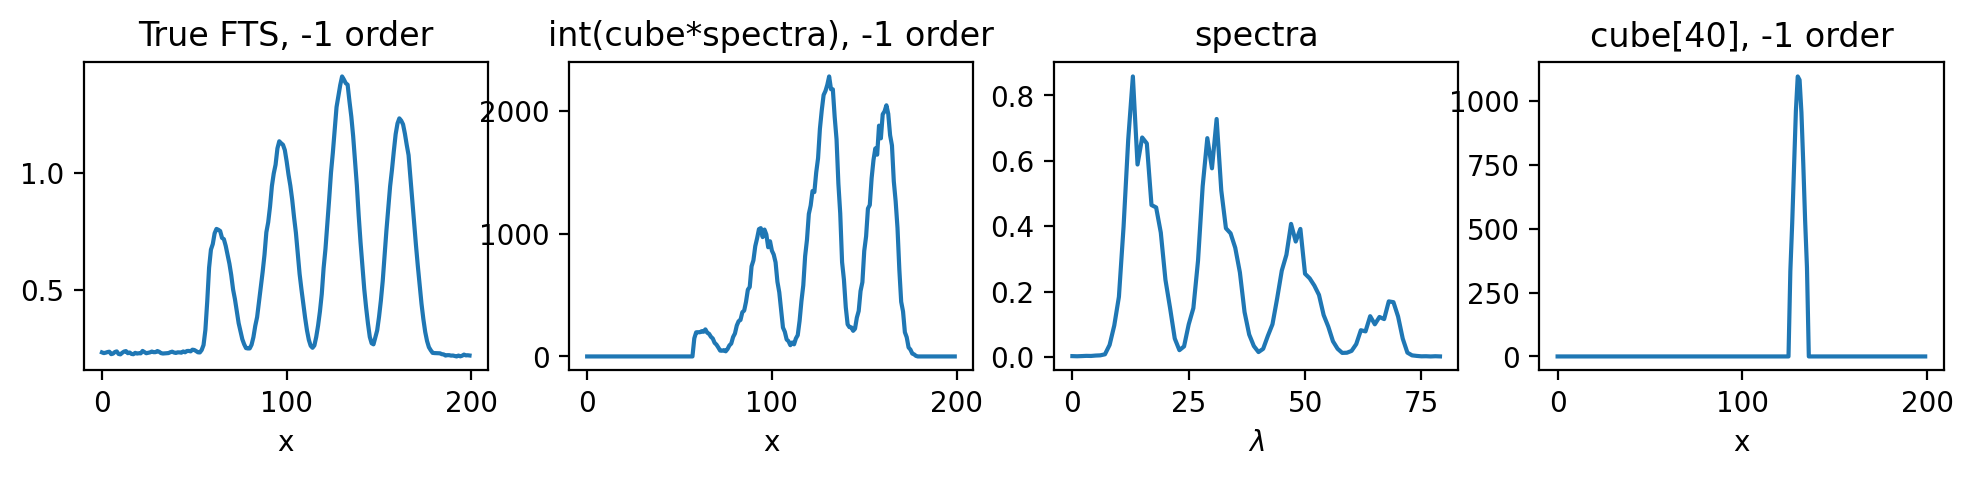

In [148]:
fig,ax = plt.subplots(1,4,figsize=(12,2),dpi=200)
ax[0].plot(true_fts[0,100:300]); ax[0].set_title('True FTS, -1 order'); ax[0].set_xlabel('x')
ax[1].plot(bla[0,100:300]); ax[1].set_title('int(cube*spectra), -1 order'); ax[1].set_xlabel('x')
ax[2].plot(spectras[:,200].cpu()); ax[2].set_title('spectra');ax[2].set_xlabel(r'$\lambda$')
ax[3].plot(bla2[0,100:300]); ax[3].set_title('cube[40], -1 order'); ax[3].set_xlabel('x')


What about with an earlier dataset

In [59]:
down_deconvolved_cube.shape

(100, 80, 151)

In [60]:
cube.shape

(100, 2448, 151)

In [83]:
cube.shape

(100, 2448, 151)

In [81]:
cube,wavls,freqs = hlp.load_cube('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230804_1grating_pinhole_analysis_exptime_80000_us/',postfix='padded_center_fixed_thresholded', onefile=False)


down_deconvolved_cube = downsample_signal(cube, desired_channels, initial_bins = wavls, interp_axis = 2, desired_range = desired_range, interp_type='average') #interpolate to 750-850nm

grating_cube = torch.tensor(down_deconvolved_cube).permute(2,0,1).unsqueeze(0).to(device).to(torch.float32)

_, spectras = hlp.create_bs_data(desired_channels=desired_channels, fts_dir = '20230804_1grating_pinhole_data_exptime_80000_us', desired_range=desired_range, device=device )

positions = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230804_1grating_pinhole_data_exptime_80000_us/positions.npy')

cutoff = [850,1200]

spectras = spectras[:,cutoff[0]:cutoff[1]]
positions = positions[cutoff[0]:cutoff[1]]  

dataset = hlp.FTSDataset(undispersed_cube=torch.zeros_like(grating_cube), spectra=spectras, positions=positions, dir = '20230804_1grating_pinhole_data_exptime_80000_us', angle = 0.28395252967192336)

indexes = [200,300]
(x,y) = dataset[indexes] 

# synthetic_fts = fwd.calc_psi_z(torch.ones_like(y),y,{'kernel':kernel})
true_fts = torch.sum(x,dim=1).cpu()

bla = torch.sum((grating_cube * spectras[:,200].unsqueeze(0).unsqueeze(2).unsqueeze(3)), dim=(1,2)).cpu()
bla = torch.sum((grating_cube[:,:30]), dim=(1,2)).cpu()


collecting the undispersed cube and spectra.


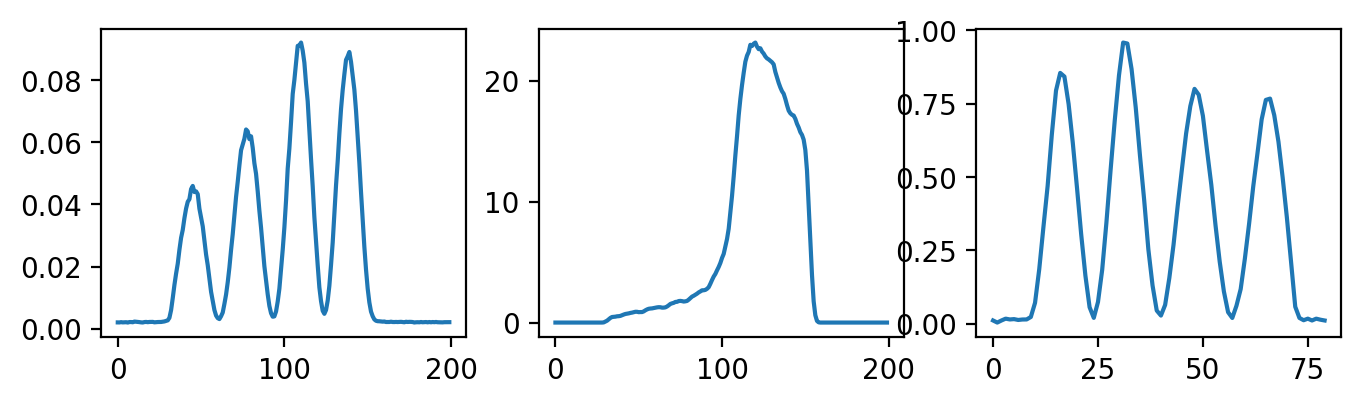

In [82]:
fig,ax = plt.subplots(1,3,figsize=(8,2),dpi=200)
ax[0].plot(true_fts[0,200:400])
ax[1].plot(bla[0,200:400])
ax[2].plot(spectras[:,200].cpu())

In [4]:
# kernel = create_fourier_kernel(desired_channels='all', desired_range=desired_range, one_grating=500).to(device)
kernel = create_fourier_kernel(desired_channels=desired_channels, desired_range=desired_range, one_grating=500).to(device)
kernel = torch.sum(kernel,dim=(2)).unsqueeze(2)

# kernel[kernel!=0] = kernel.max()
# kernel = kernel / kernel.mean(dim=(0,3,2),keepdim=True)

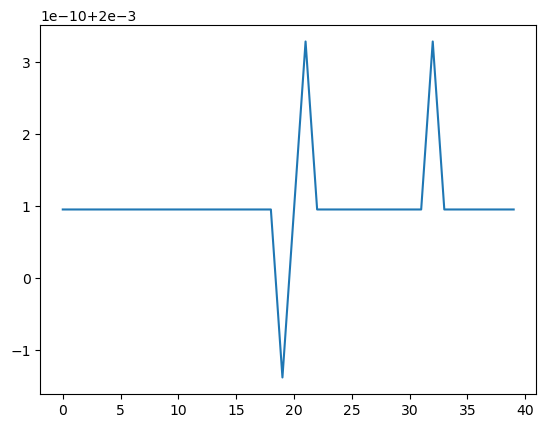

In [5]:
plt.plot(kernel[...,:500].mean(dim=(0,3,2)).cpu())


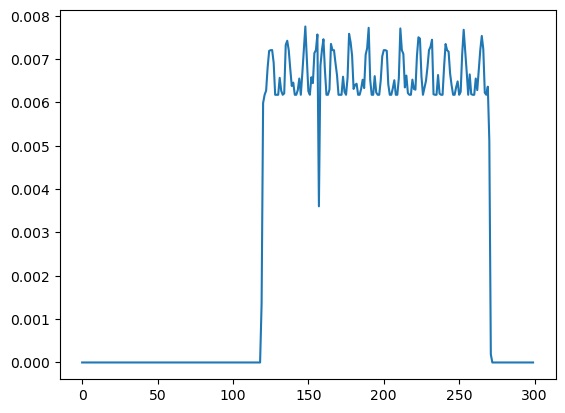

In [6]:
plt.plot(kernel[...,100:400].cpu().mean(dim=(0,1,2)))

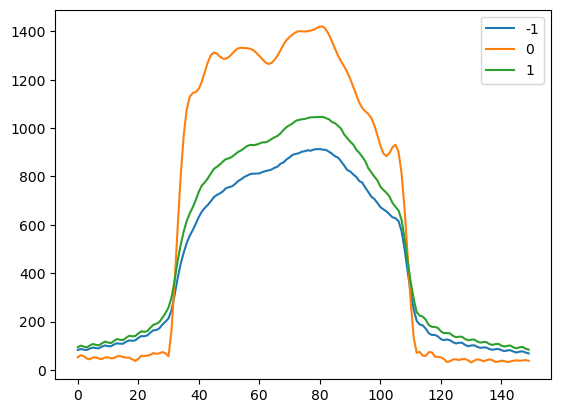

In [7]:
plt.plot(np.sum(cube[:400],axis=0))
plt.plot(np.sum(cube[800:1600],axis=0))
plt.plot(np.sum(cube[1600:],axis=0))
plt.legend(('-1','0','1'))

Text(0.5, 1.0, 'Deconvolved')

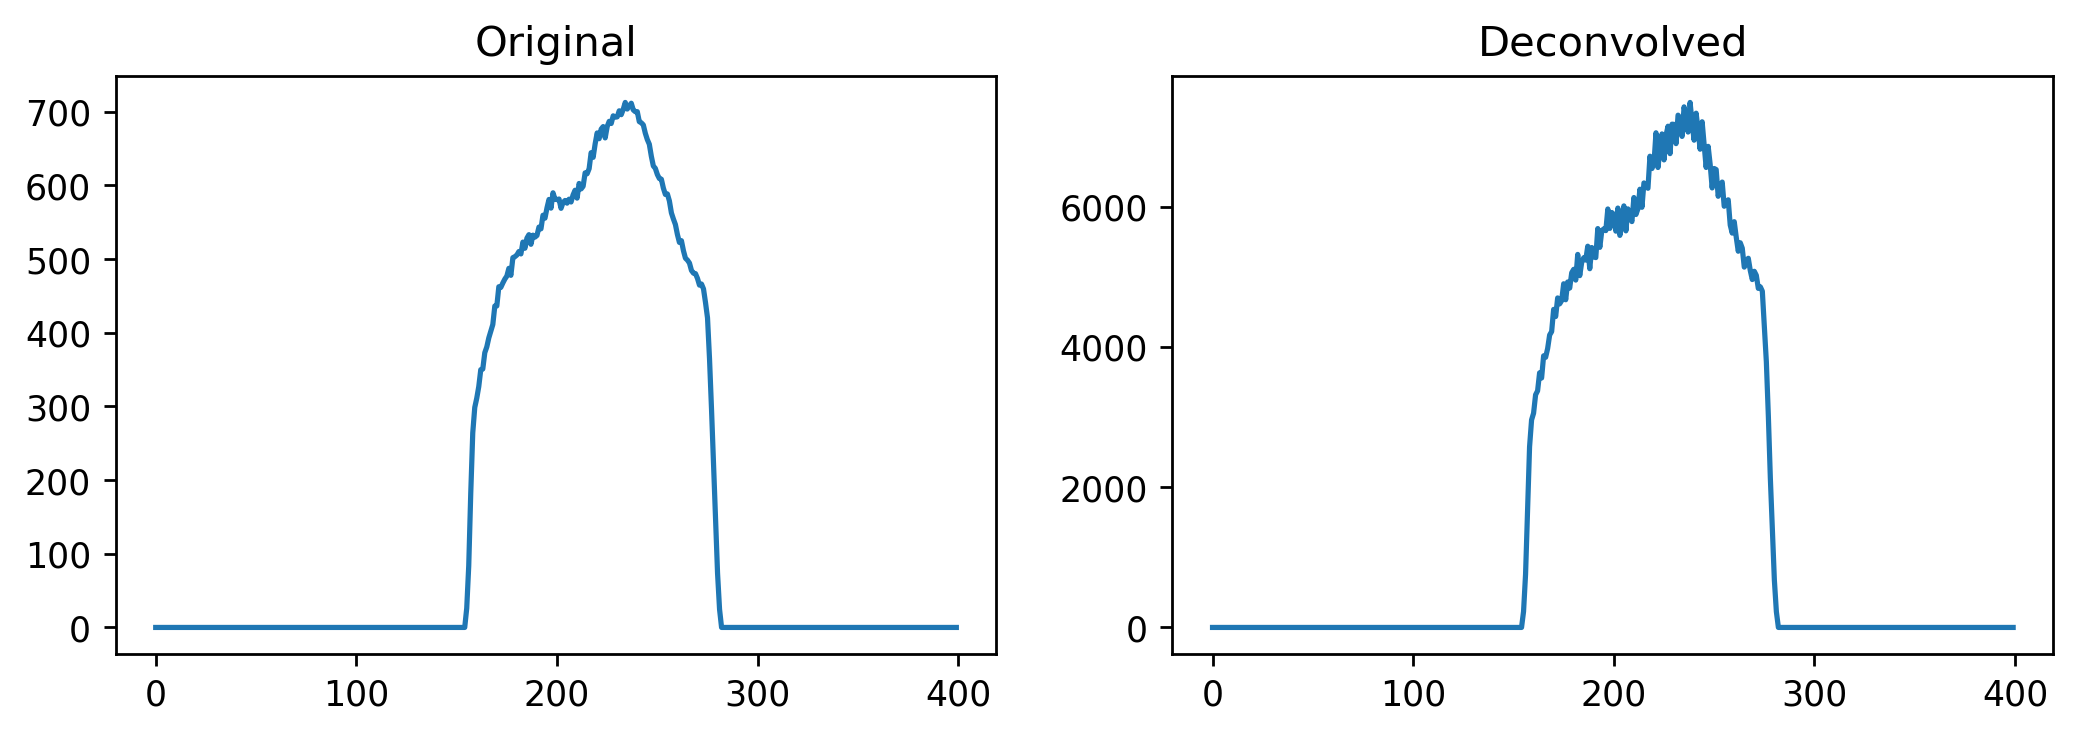

In [8]:
fig,ax = plt.subplots(1,2,figsize=(10,3),dpi=250)
ax[0].plot(np.sum(cube[:400],axis=1)); ax[0].set_title('Original')
ax[1].plot(np.sum(deconvolved_cube[:400],axis=1)); ax[1].set_title('Deconvolved')

## Go from nograting cube to grating cube with grad descent


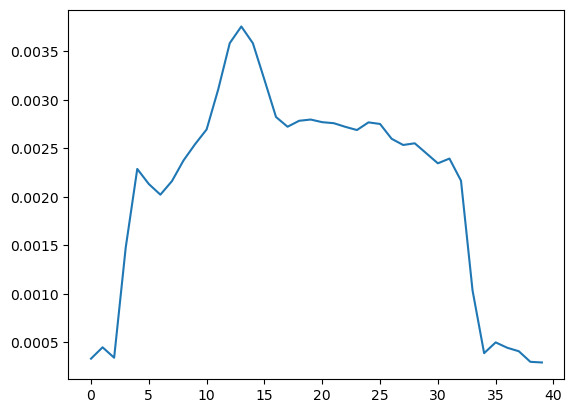

In [88]:
plt.plot(torch.mean(nograting_cube,(0,2,3)).cpu())

In [15]:
zeros = torch.zeros_like(nograting_cube)

middle = torch.where(nograting_cube == nograting_cube.max())[2:]

zeros[0,...,middle[0]-10:middle[0]+10,middle[1]-10:middle[1]+10] = nograting_cube[0,...,middle[0]-10:middle[0]+10,middle[1]-10:middle[1]+10]
nograting_cube = zeros

nograting_cube = torch.sum(nograting_cube,dim=2).unsqueeze(2)

def threshold(cube, t = 0.001):
    cube[cube<t*cube.max()] = 0
    return cube

grating_cube = threshold(grating_cube)
nograting_cube = threshold(nograting_cube)


#lets shift fundamentals of both to the center
center = grating_cube.shape[3] //2


region = np.array([[0,1],[1000,1400]])

CoMgrating = CenterOfMassLoss.calculate_center_of_mass(torch.sum(grating_cube,dim=1), region)[0].cpu()[1]+1000
CoMnograting = CenterOfMassLoss.calculate_center_of_mass(torch.sum(nograting_cube,dim=1), region)[0].cpu()[1]+1000

grating_cube = torch.tensor(scipy.ndimage.shift(grating_cube.cpu(), shift = (0,0,0,center - CoMgrating), order = 1)).to(device)
nograting_cube = torch.tensor(scipy.ndimage.shift(nograting_cube.cpu(), shift = (0,0,0,center - CoMnograting), order = 1)).to(device)

nograting_cube = nograting_cube  / nograting_cube.mean()  #remove this once normalisation is done
grating_cube = grating_cube / grating_cube.mean() * 0.8

grating_cube = grating_cube / nograting_cube.max()
nograting_cube = nograting_cube / nograting_cube.max()


In [90]:
grating_cube.max(), nograting_cube.max(), grating_cube.mean(), nograting_cube.mean()


(tensor(0.2098, device='cuda:2'),
 tensor(1., device='cuda:2'),
 tensor(0.0003, device='cuda:2'),
 tensor(0.0003, device='cuda:2'))

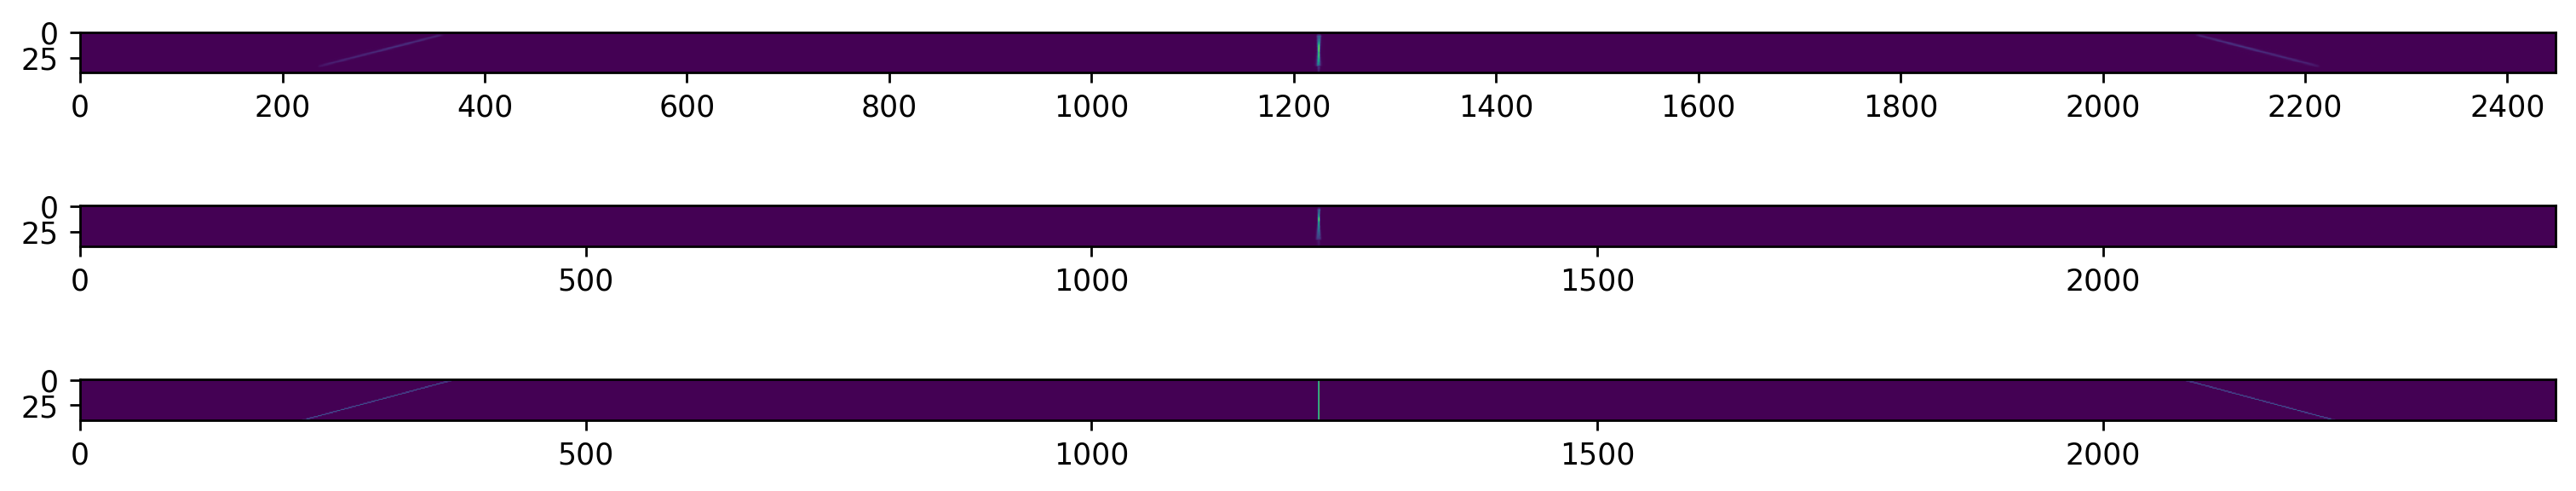

<Figure size 1600x1200 with 0 Axes>

In [91]:

fig,ax = plt.subplots(3,1,dpi=250, figsize = (15,3))
ax[0].imshow(grating_cube[0,:,0].cpu())
ax[0].set_xticks(np.arange(0,2500,200))
plt.figure(dpi=250)
ax[1].imshow(nograting_cube[0,:,0].cpu())
ax[2].imshow(kernel[0,:,0].cpu())

### Find a multiplication factor between them?

In [92]:
cluster_points = 3

pos = np.array([[[0,1],[150, 450]], [[0,1],[1200,1300]],[[0,1], [2000,2300]]])

In [93]:
init_guess = fwd.disperser.disperse_all_orders(nograting_cube,kernel)

scaled_kernel = kernel* (grating_cube.mean() / init_guess.mean())

# for i in range(cluster_points):
#     fac = grating_cube[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]].mean(dim=(0,2,3)) / init_guess[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]].mean(dim=(0,2,3))

#     scaled_kernel[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]] = scaled_kernel[:,:,pos[i,0,0]:pos[i,0,1],pos[i,1,0]:pos[i,1,1]] * fac[None,:,None,None]


In [94]:
kernel.shape

torch.Size([1, 40, 1, 2448])

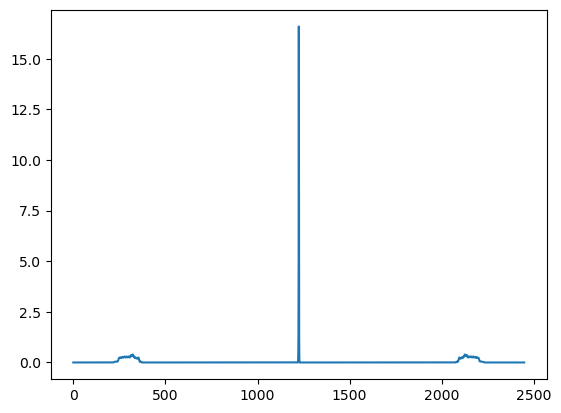

In [95]:
plt.plot(torch.sum(init_guess,dim=(0,1,2)).cpu())

In [103]:
init_guess = fwd.disperser.disperse_all_orders(nograting_cube,scaled_kernel) 

for i in range(cluster_points):
    
    loss_fn2 = CenterOfMassLoss(pos[i:i+1], intensity_factor= 3, funda_weight=1, funda_index=1) 
    print(loss_fn2(grating_cube,init_guess))


epochs =200

model = AffineTransformModel(region = pos, rot=0., transX=0., transY=0.,scale=True, no_channels=desired_channels).to(device)

loss_fn1 = torch.nn.MSELoss()
loss_fn2 = CenterOfMassLoss(pos, intensity_factor= 3, funda_weight=1, funda_index=1) 


loss = loss_fn1(init_guess,grating_cube) + loss_fn2(init_guess,grating_cube)  * 1e-5
lr = 1e-3


optimizer = torch.optim.Adam(model.parameters(), lr=lr)




torch.cuda.empty_cache()


tensor(12.5816, device='cuda:2')
tensor(0.5480, device='cuda:2')
tensor(13.8618, device='cuda:2')


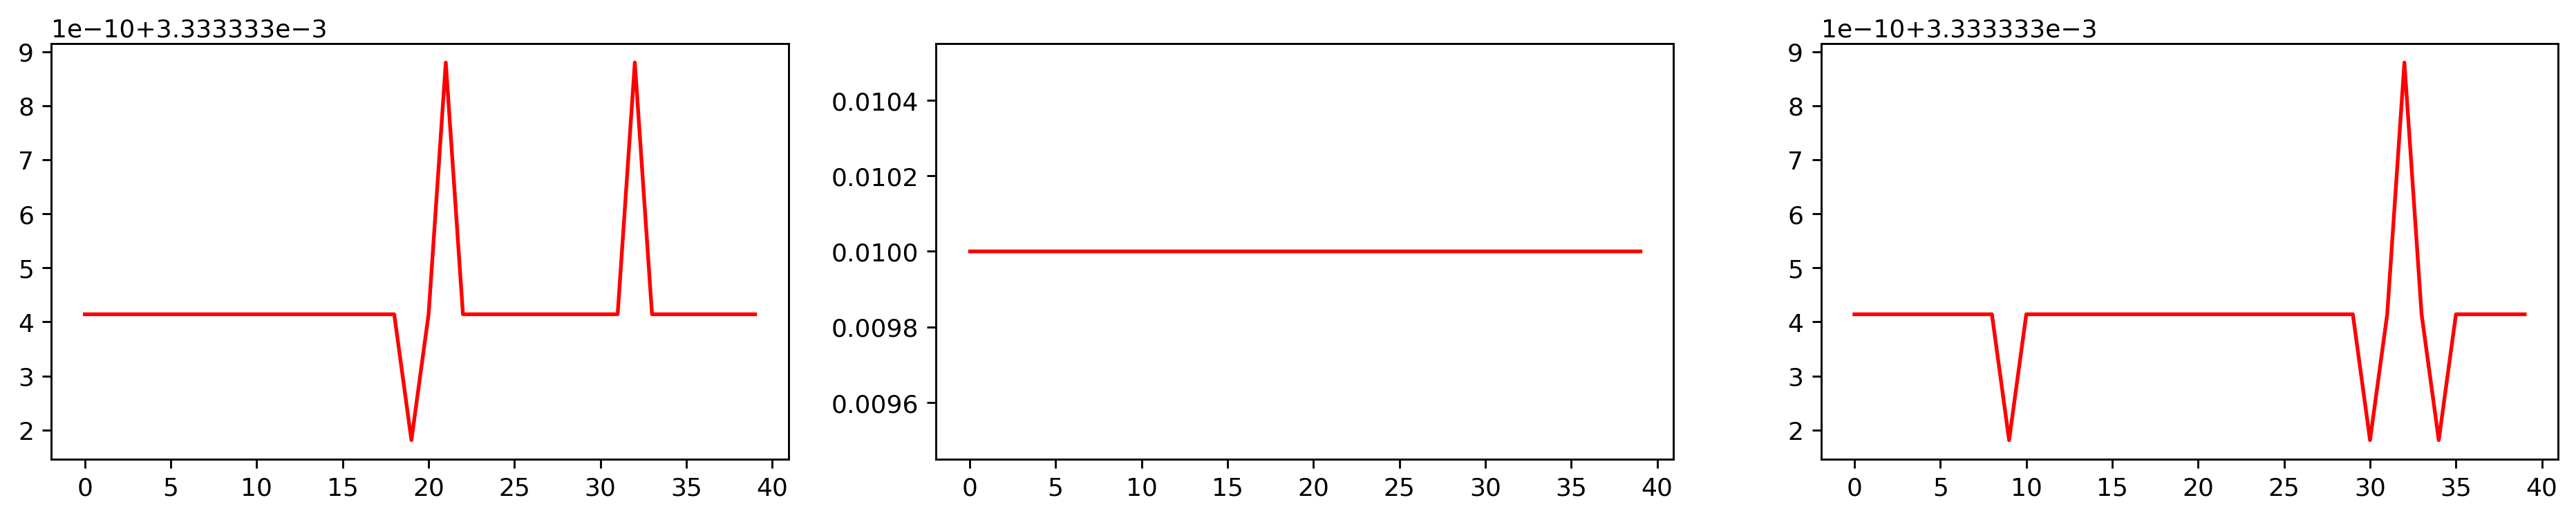

In [104]:
fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    ax[i].plot(kernel[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'r');
    # print(kernel[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T)


In [105]:
scaled_kernel.max()

tensor(0.2667, device='cuda:2')

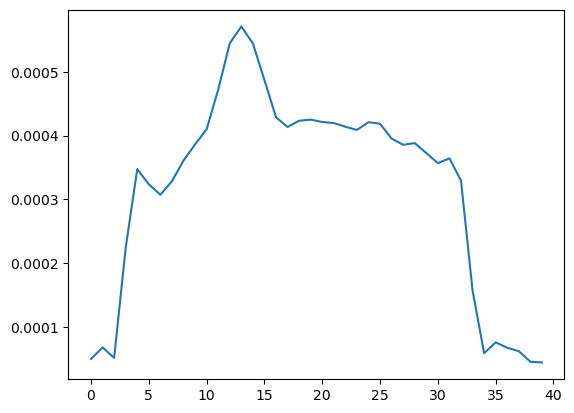

In [106]:
plt.plot(torch.mean(nograting_cube,dim=(0,2,3)).cpu())

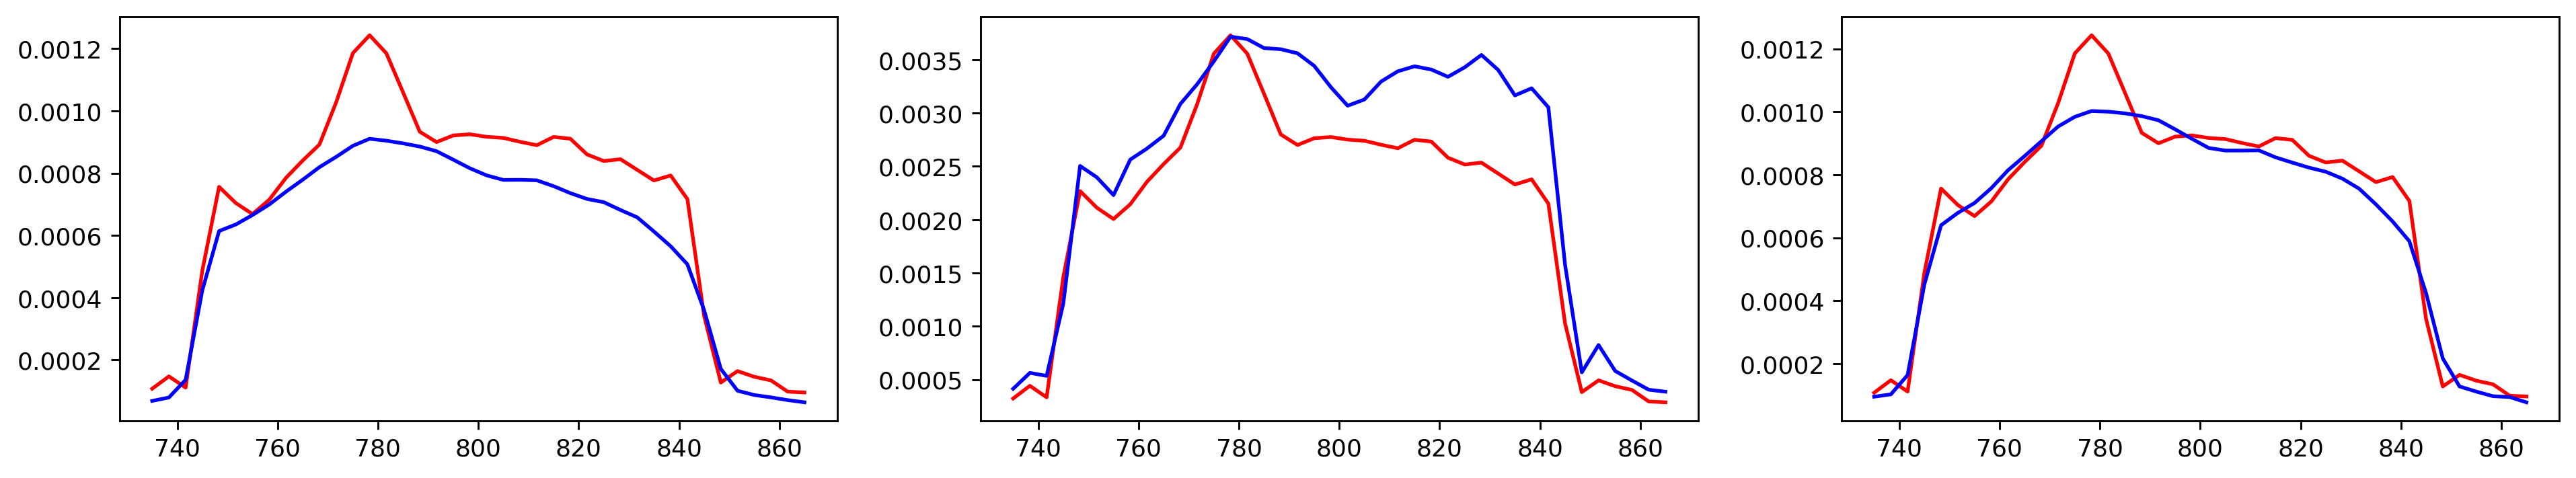

In [107]:
yhat_init = fwd.disperser.disperse_all_orders(nograting_cube,scaled_kernel)

fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),yhat_init[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'r');
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),grating_cube[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'b');

In [108]:
model.fit_angles(truth = grating_cube, init_guess=init_guess, funda_idx = cluster_points//2)
affine_kernel = model(scaled_kernel)
    
yhat_rot = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)


In [109]:
model.fit_translation(truth = grating_cube, init_guess=yhat_rot, intensity_factor = 2)

affine_kernel = model(scaled_kernel)    
yhat_rot_trans = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

In [110]:
store2 = torch.zeros((cluster_points,2,2))

for i in range(cluster_points):
    diff = []

    for l in range(10,20):
        guess = loss_fn2.calculate_center_of_mass(yhat_rot_trans[:,l],region = pos[i])
        true = loss_fn2.calculate_center_of_mass(grating_cube[:,l],region = pos[i])

        diff.append(true - guess)

    diff = torch.stack(diff)

    store2[i,0] = torch.mean(diff,dim=0)
    store2[i,1] = torch.std(diff,dim=0)
    

In [111]:
store2

tensor([[[ 0.0000, -0.9788],
         [ 0.0000,  0.6930]],

        [[ 0.0000,  0.0273],
         [ 0.0000,  0.0544]],

        [[ 0.0000,  0.7165],
         [ 0.0000,  1.0069]]], grad_fn=<CopySlices>)

In [112]:
lr = 4e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 200

In [113]:
history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['mse'] = []



start_time_sec = time.time()
num_train_examples = 1

for epoch in range(1, epochs+1):
    torch.cuda.empty_cache()


    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    optimizer.zero_grad()


    affine_kernel = model(scaled_kernel)
    
    yhat = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

    mse = loss_fn1(yhat, grating_cube)
    
    loss =  mse + loss_fn2(yhat, grating_cube[:,:]) * 1e-5
    # loss =  loss_fn2(yhat, grating_cube)  

    loss.backward()
    optimizer.step()

    train_loss        = loss.data.item() * grating_cube.size(0)
    train_mse        = mse.data.item() * grating_cube.size(0)





    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}: , train loss: {(train_loss/num_train_examples):5.5g}, train mse: {(train_mse/num_train_examples):5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['loss'].append(train_loss)
    history['mse'].append(train_mse)


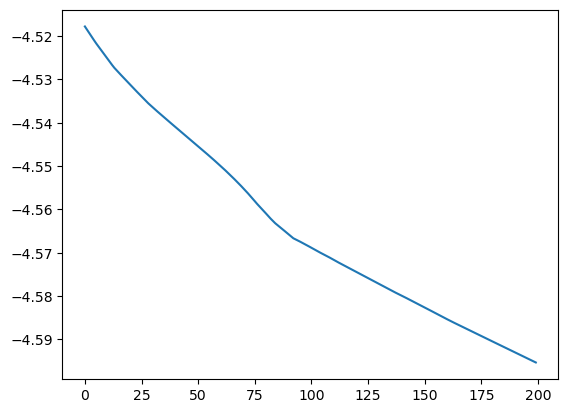

In [114]:
plt.plot(np.log10(history['loss']))


In [115]:
init_guess = fwd.disperser.disperse_all_orders(nograting_cube,kernel)

affine_kernel = model(scaled_kernel)
yhat = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)


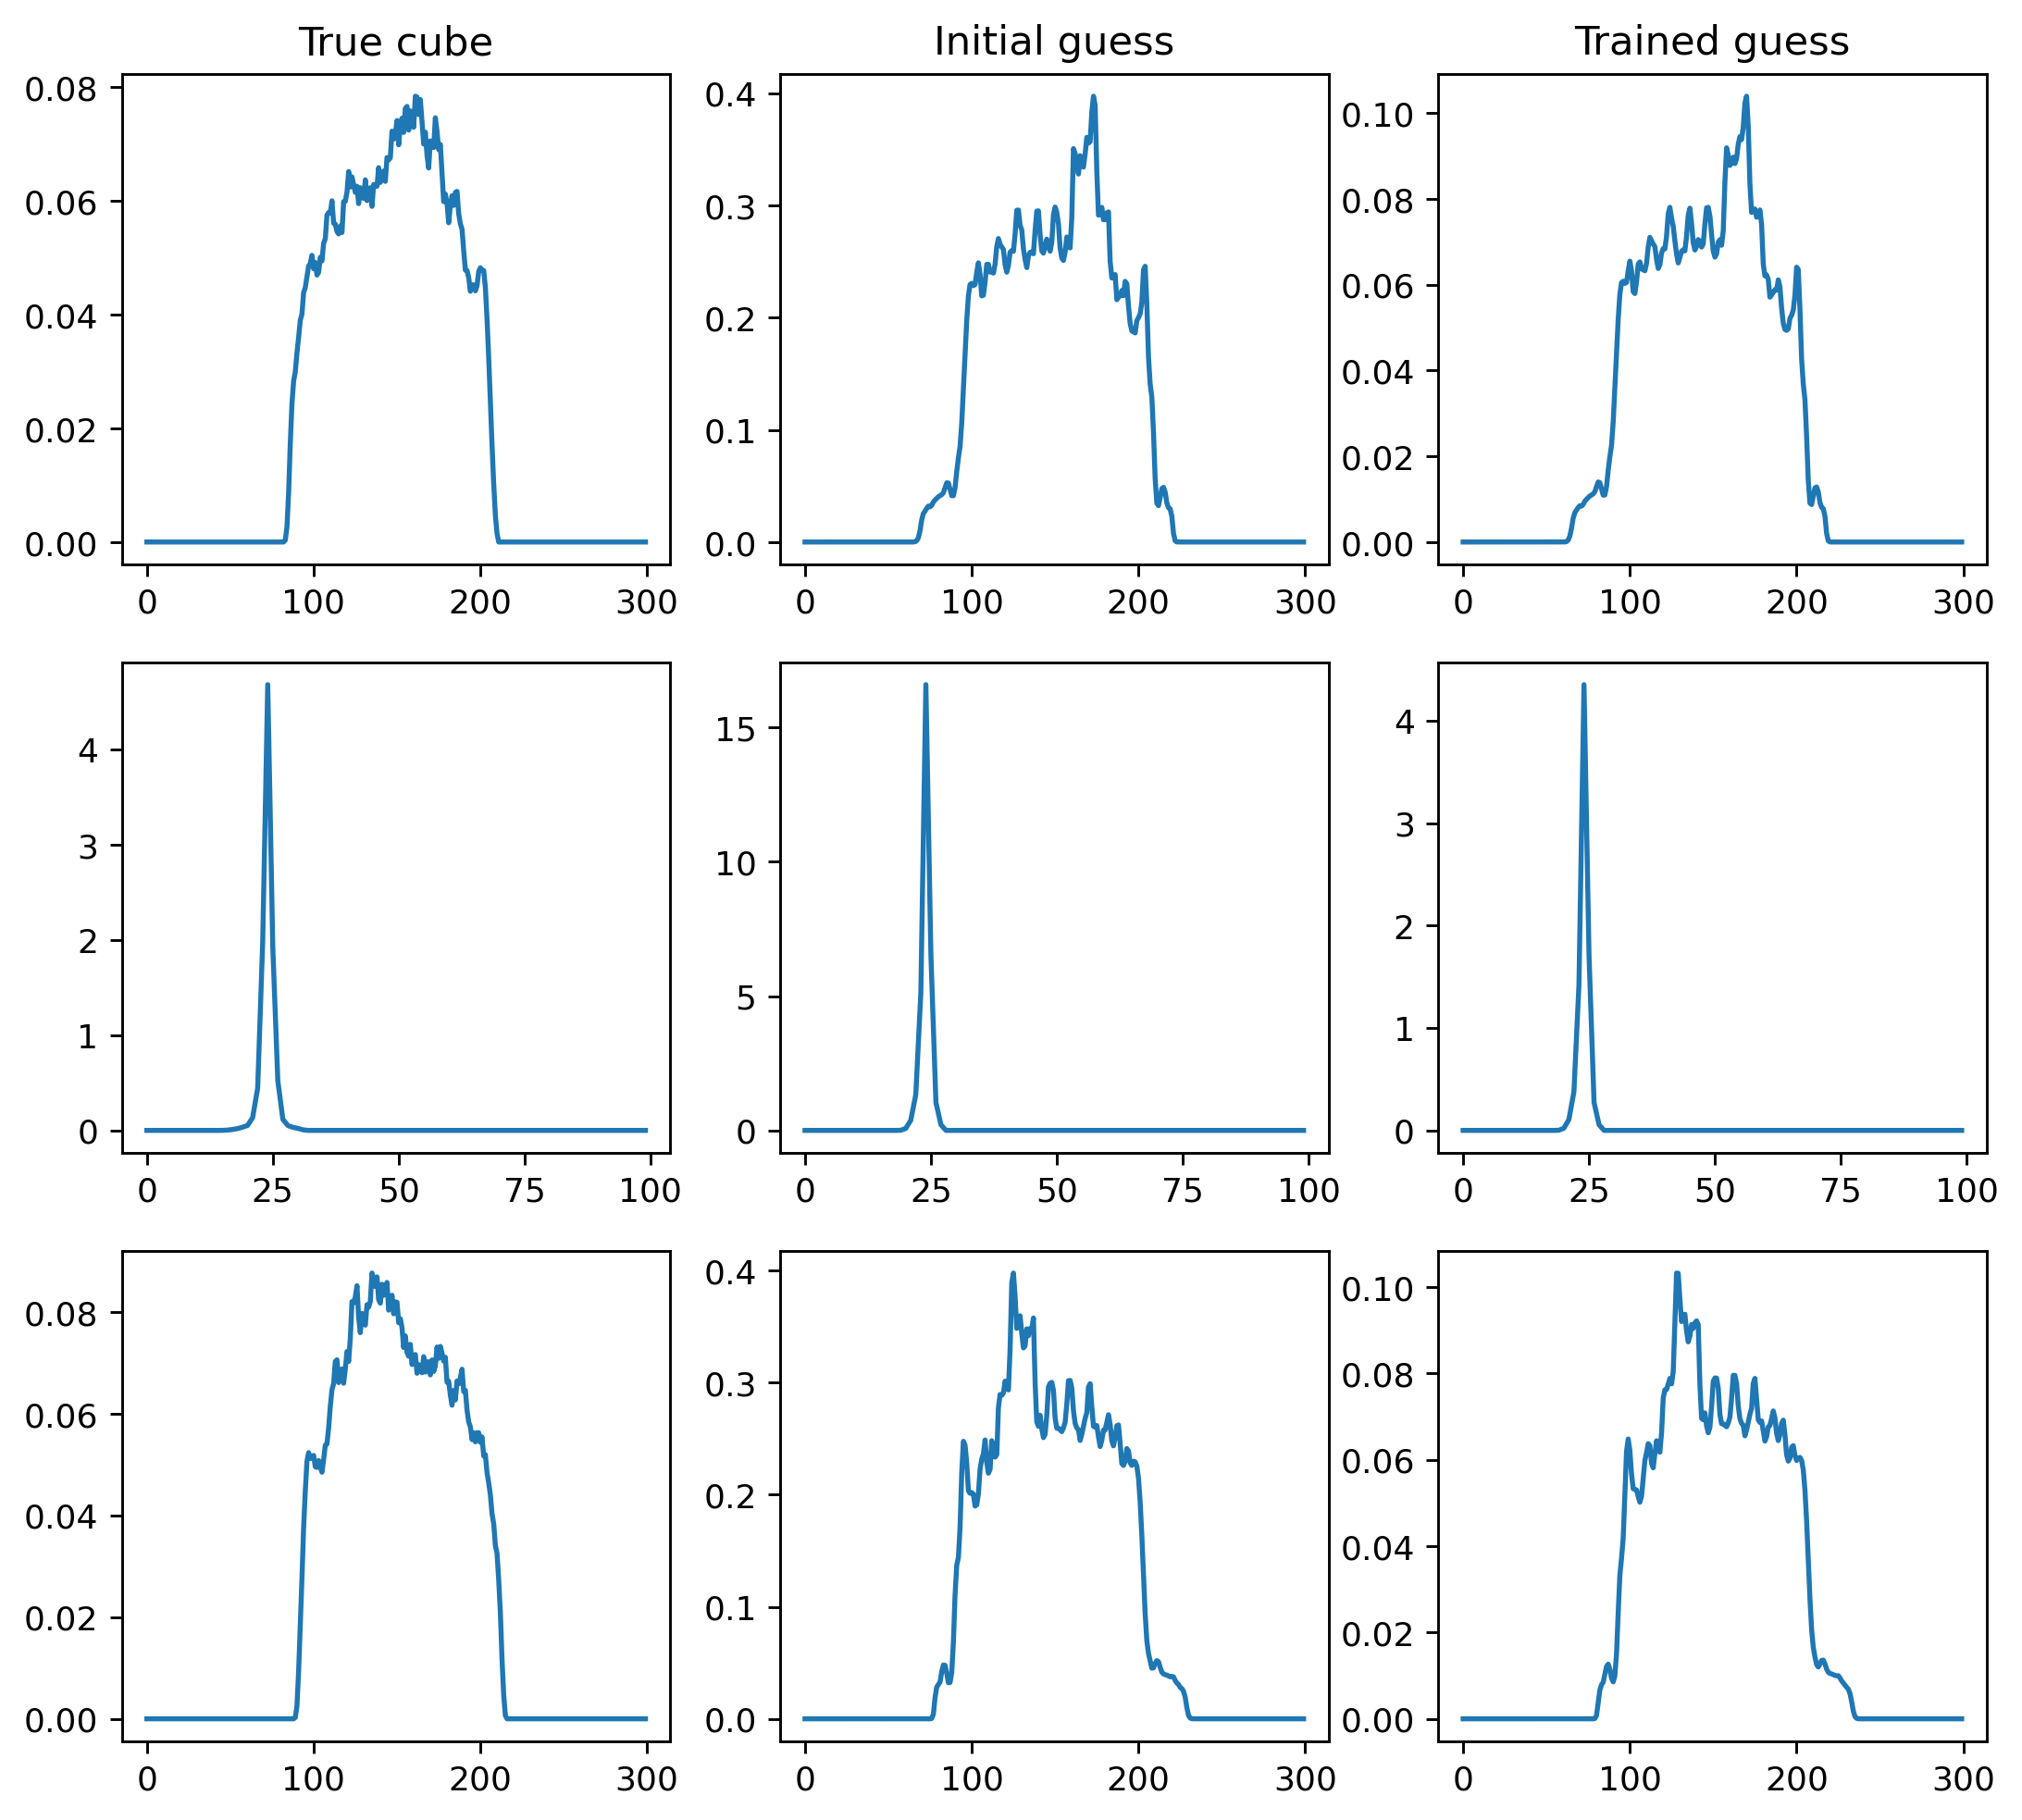

In [116]:
plot_orders = [0,1,2]

fig,ax = plt.subplots(len(plot_orders),3,figsize=(10,9),dpi=260)

for n,i in enumerate(plot_orders):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]#[200,400]
    


    ax[n,0].plot(torch.sum(grating_cube[0,:,0,b3:b4],dim=0).cpu().detach().numpy()); ax[0,0].set_title('True cube')
    ax[n,1].plot(torch.sum(init_guess[0,:,0,b3:b4],dim=0).cpu().detach().numpy()); ax[0,1].set_title('Initial guess')
    ax[n,2].plot(torch.sum(yhat[0,:,0,b3:b4],dim=0).cpu().detach().numpy()); ax[0,2].set_title('Trained guess')




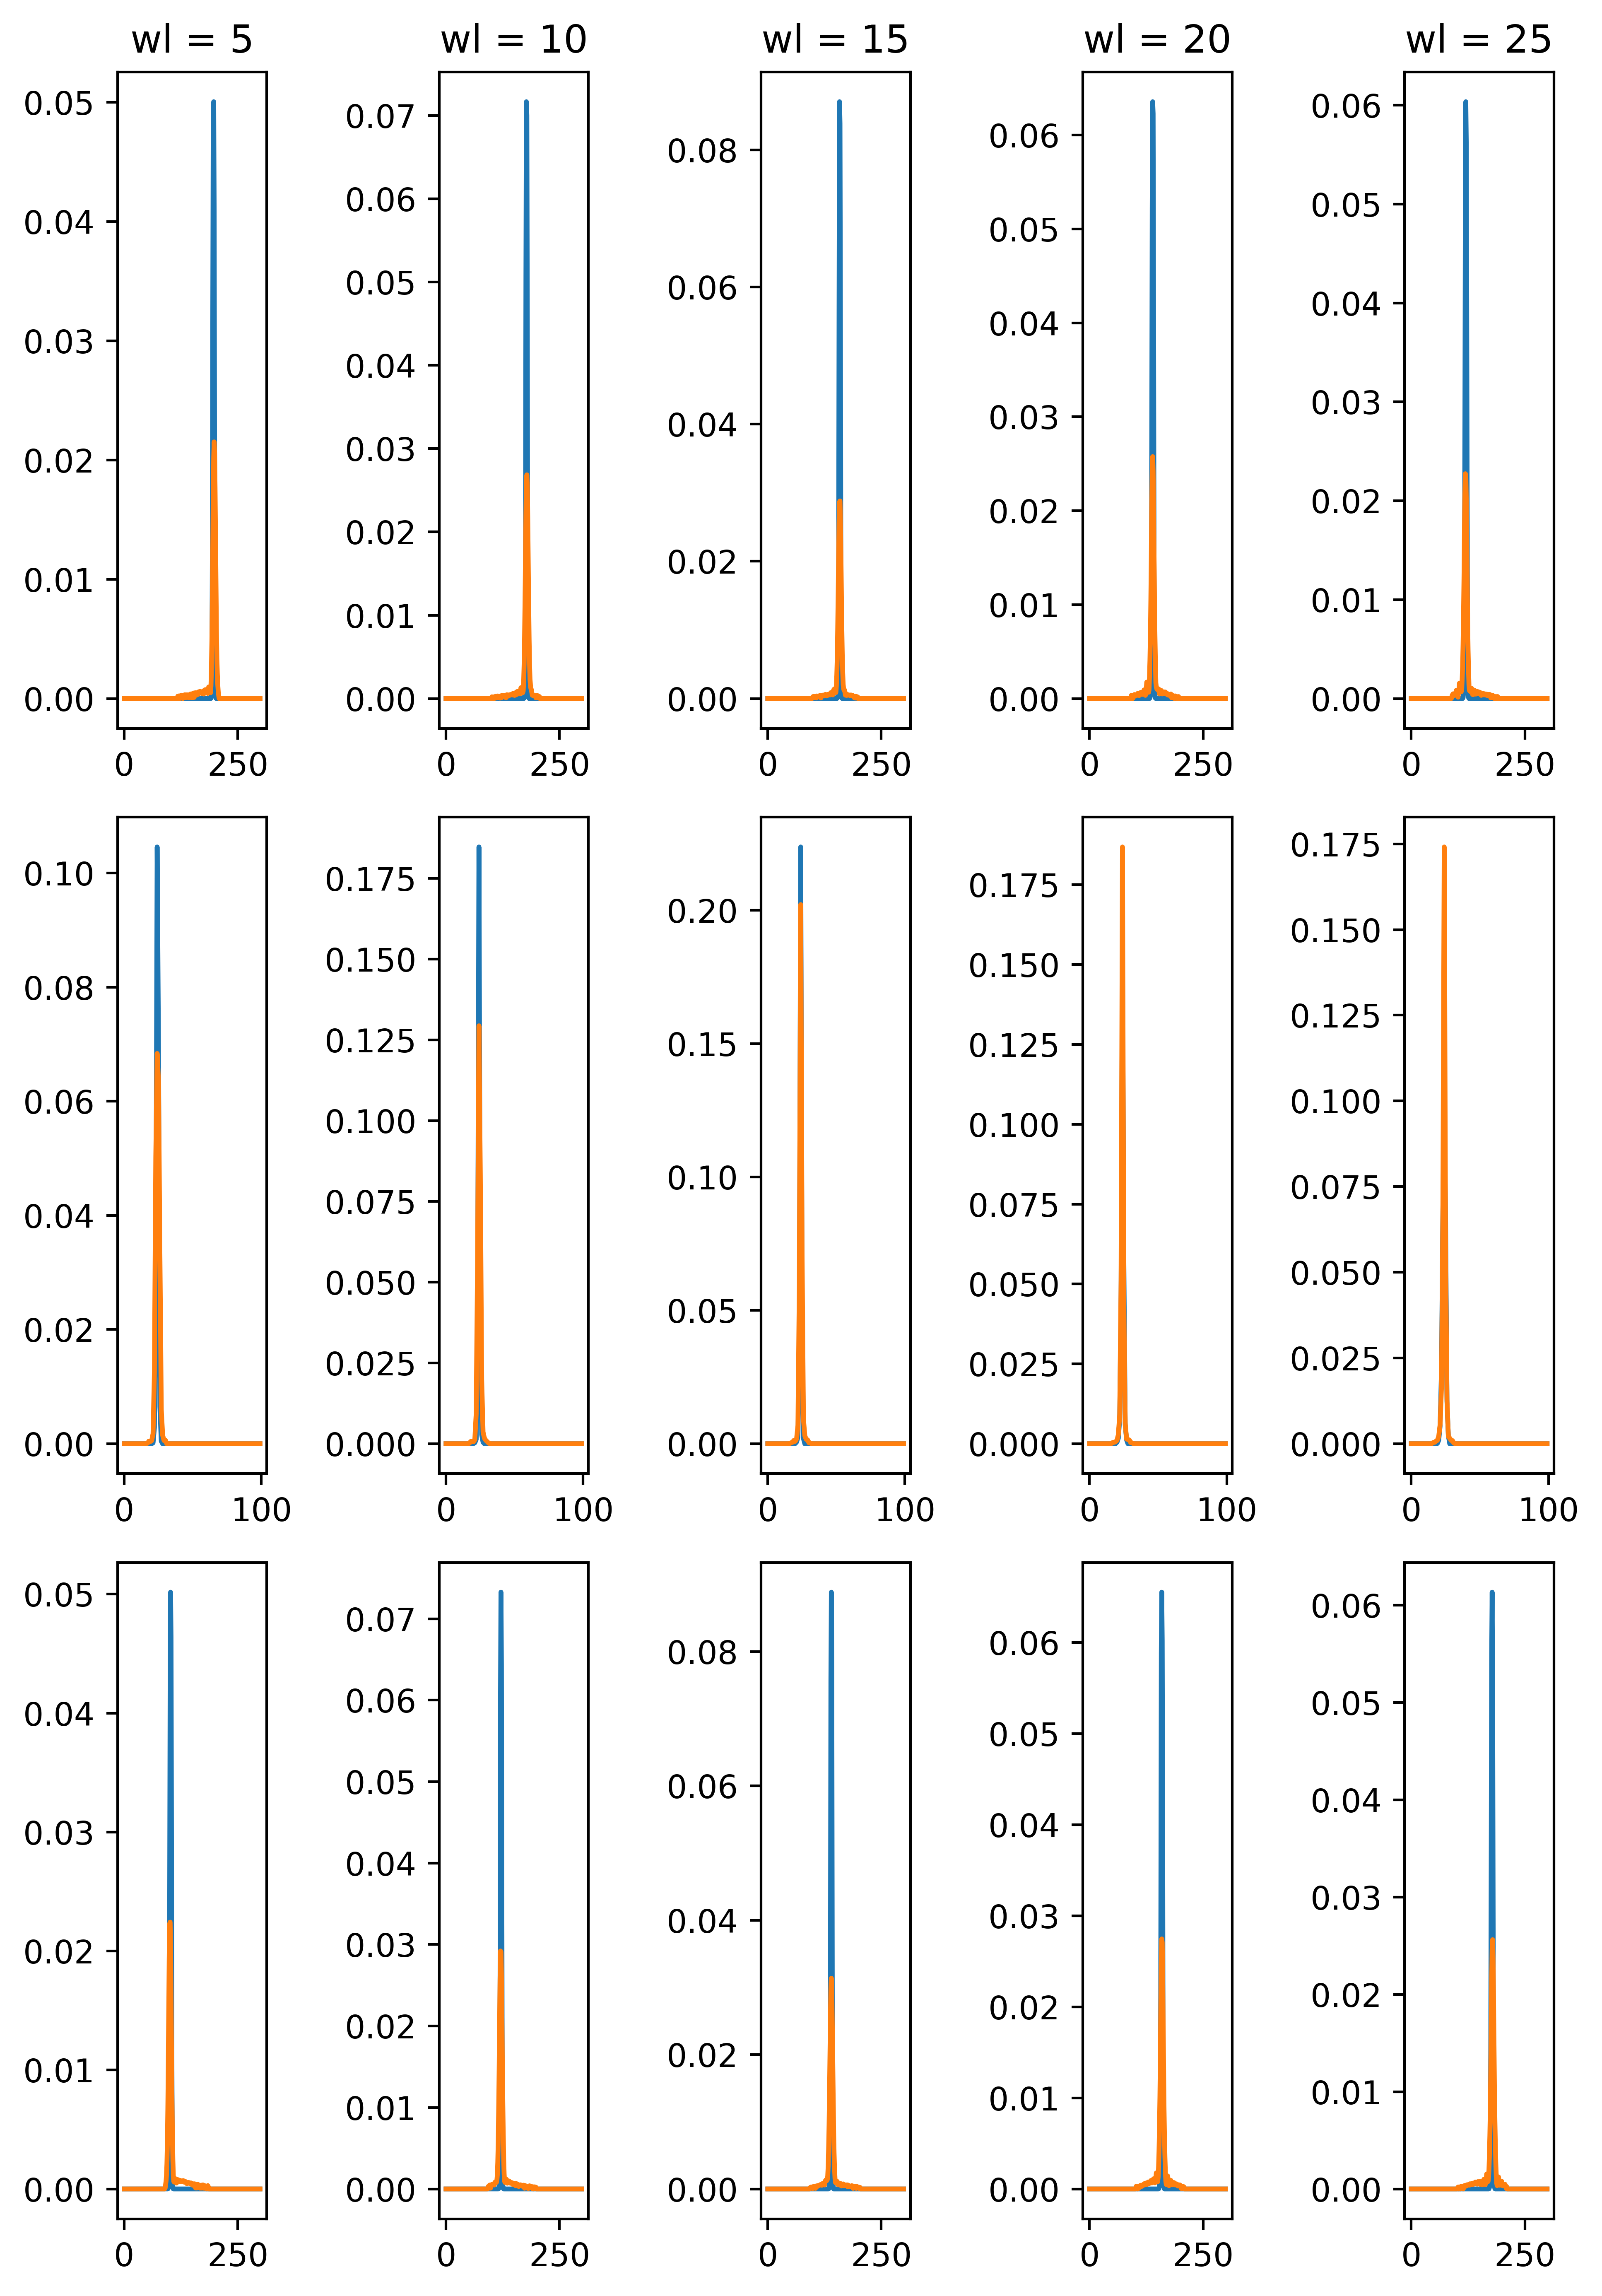

In [117]:
wls = [5,10,15,20,25]


fig,ax = plt.subplots(cluster_points,5,figsize=(7,10),dpi=560)

for j in range(len(wls)):
    ax[0,j].set_title(f'wl = {wls[j]}')

for i in range(len(pos)):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]
    for j in range(len(wls)):# com = loss_fn2.calculate_center_of_mass(grating_cube[:,wls[j]],pos[i]).cpu().detach().numpy()
        # ax[i,j].plot(com[0][1],com[0][0],'r.',markersize=0.2)
        ax[i,j].plot(yhat[0,wls[j],0,b3:b4].cpu().detach().numpy())
        ax[i,j].plot(grating_cube[0,wls[j],0,b3:b4].cpu().detach().numpy())

fig.tight_layout()

In [118]:
# plt.plot(model.grating_spectrum.detach().cpu().T);

In [119]:
yhat_affine = yhat.clone()

In [120]:
torch.save(affine_kernel, '../affine_kernel.pt')

## Now that the kernel is in the right position spatially, we make the whole thing trainable.

In [121]:
affine_kernel = torch.load('../affine_kernel.pt',map_location=device).requires_grad_(False)


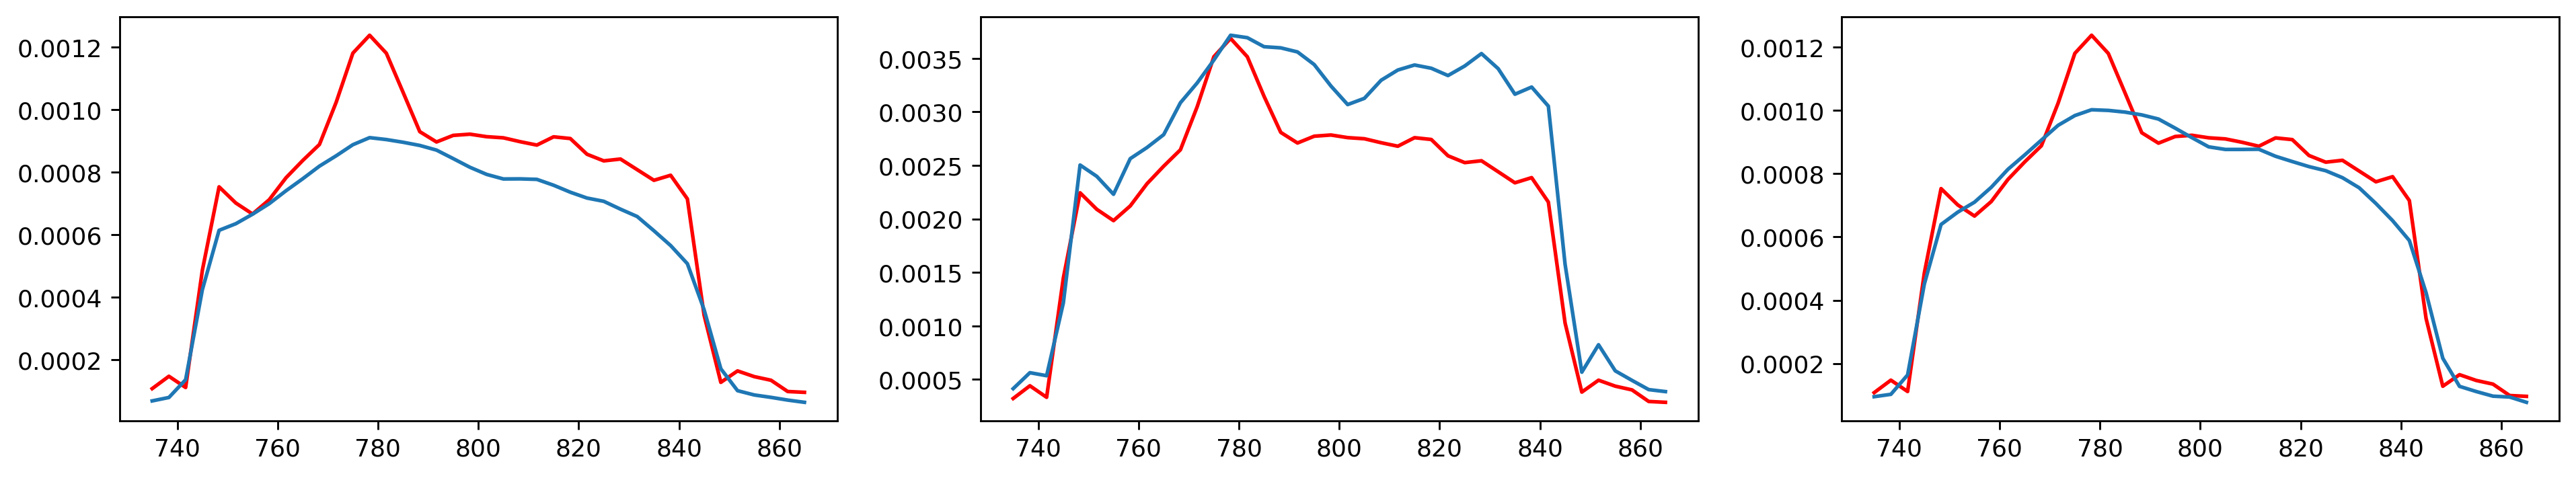

In [125]:
yhat_affine = fwd.disperser.disperse_all_orders(nograting_cube,affine_kernel)

fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),yhat_affine[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T,'r');
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),grating_cube[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T);

In [126]:
padding = 10


fine_model = KernelLearner(kernel=affine_kernel.clone(), padding=padding).to(device) 
# fine_model = GratingModulationLearner(kernel = affine_kernel.clone(), regions = pos).to(device)

In [127]:

lr = 1e-4
epochs = 3000

optimizer = torch.optim.Adam(fine_model.parameters(), lr=lr)

init_guess = fine_model(nograting_cube)

loss_fn = torch.nn.MSELoss()

loss = loss_fn(init_guess,grating_cube)
print(loss)

tensor(4.3248e-06, device='cuda:2', grad_fn=<MseLossBackward0>)


In [128]:
history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['mse'] = []





start_time_sec = time.time()

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    fine_model.train()
    num_train_examples = 1

    optimizer.zero_grad()
    
    yhat = fine_model(nograting_cube)
    loss = loss_fn(yhat, grating_cube)

    loss.backward()
    optimizer.step()

    train_loss         = loss.data.item() * grating_cube.size(0)
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')


    history2['mse'].append(train_loss)


    


Text(0.5, 0, 'Epochs')

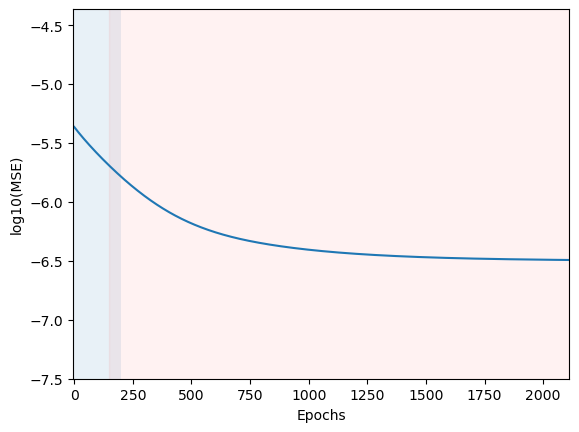

In [129]:

mina, maxa = np.log10(history2['mse']).min(), np.log10(history2['mse']).max()

plt.plot(np.log10(history2['mse']))
# plt.plot(np.log10(history['mse']+history2['mse']))
plt.fill_betweenx(np.linspace(-9,1,100),-1,200,alpha=0.1)
plt.fill_betweenx(np.linspace(-9,1,100),150,2109,color='r',alpha=0.05)

plt.xlim([-5,2110])
plt.ylim([mina-1,maxa+1])
plt.ylabel('log10(MSE)')
plt.xlabel('Epochs')

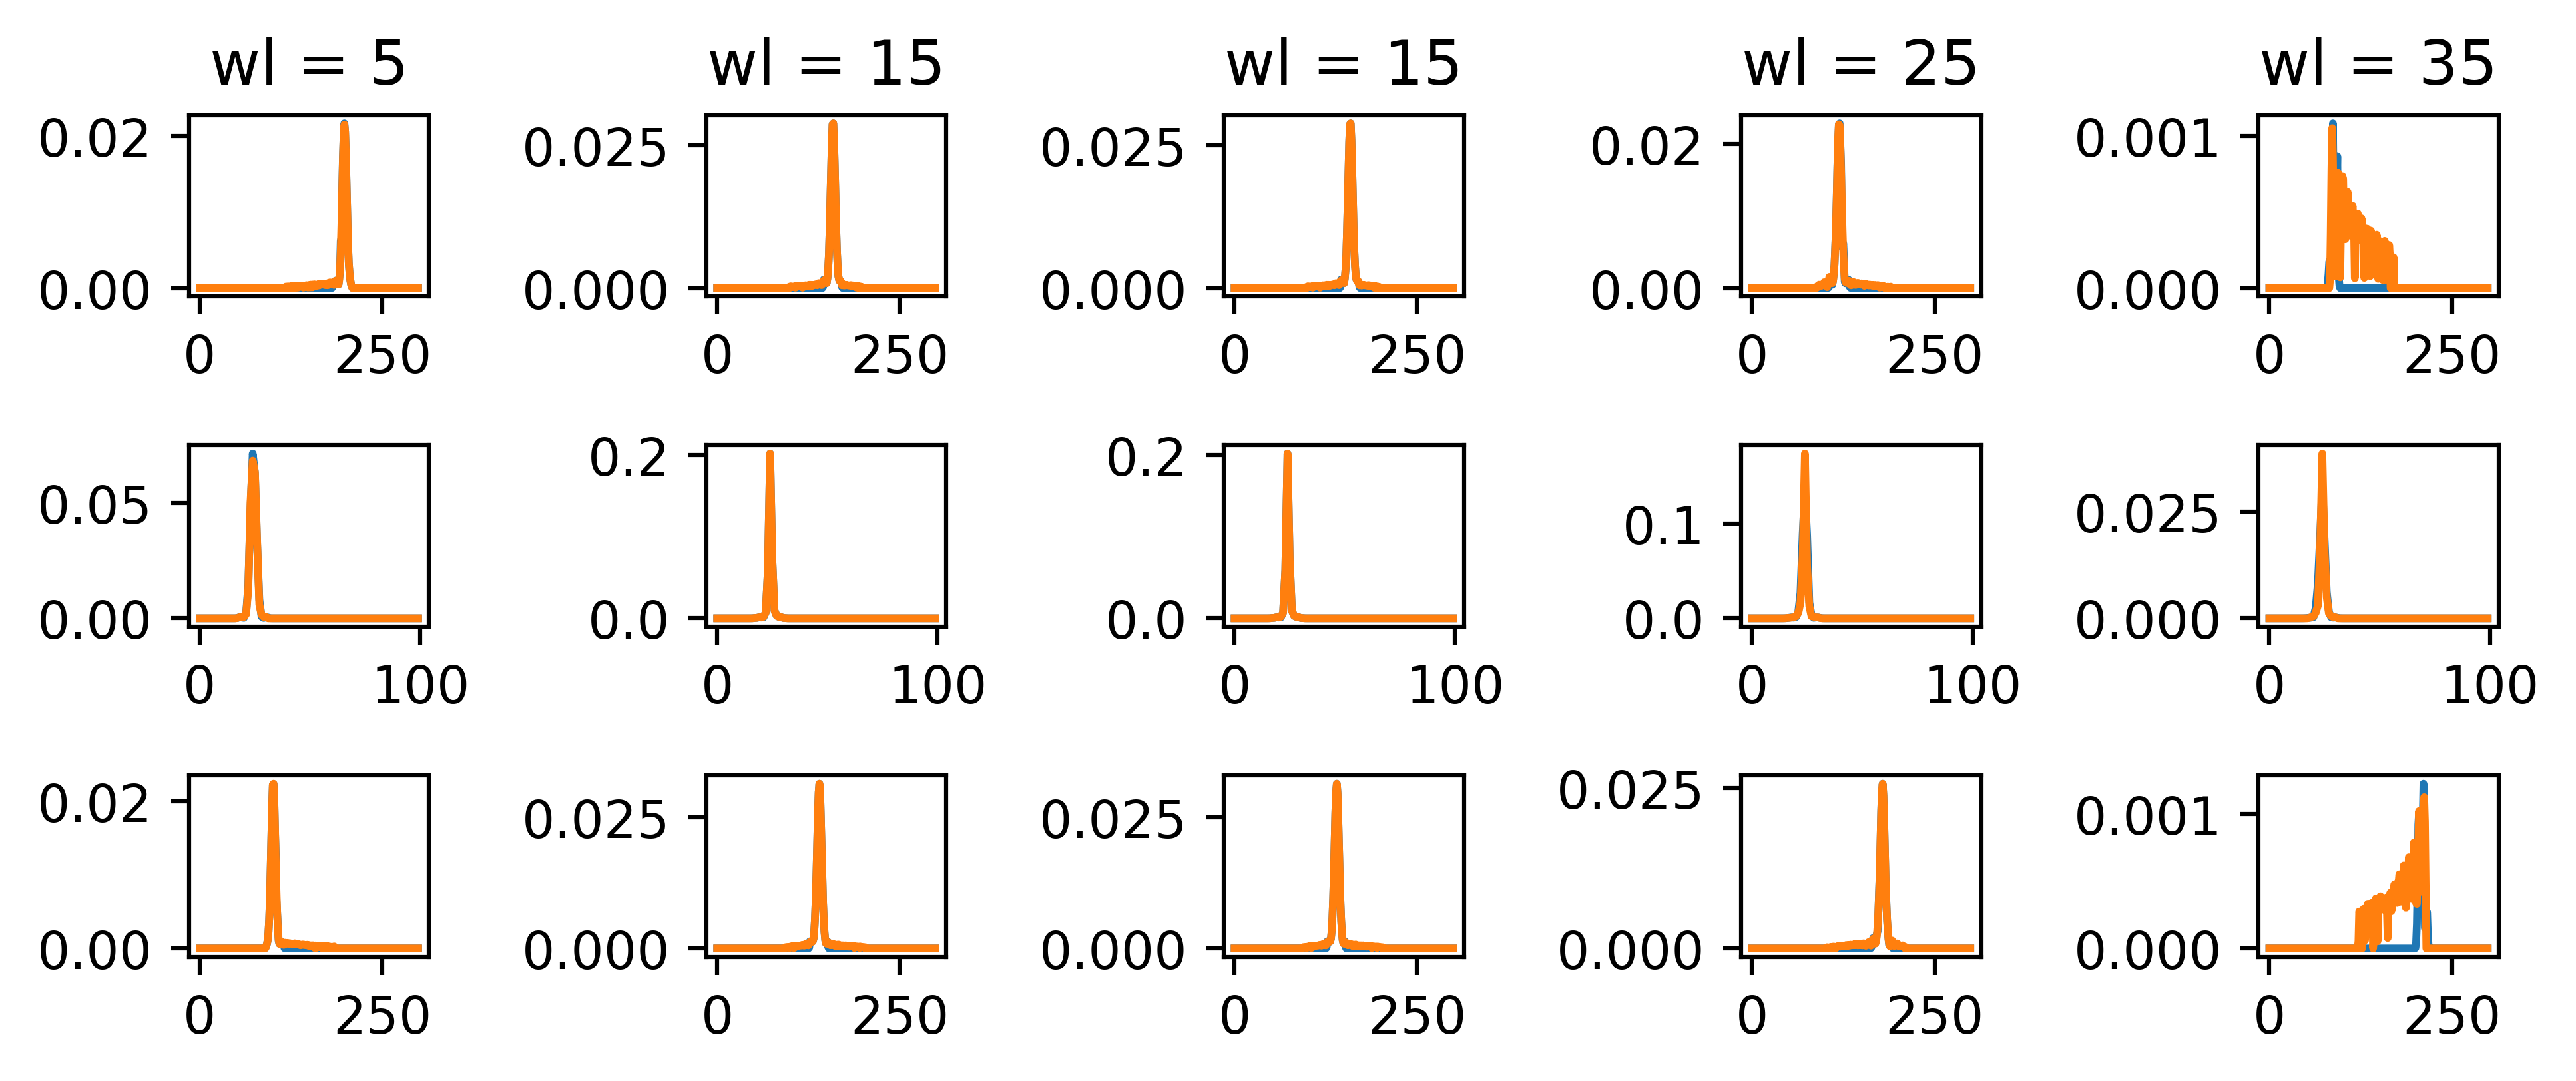

In [130]:
trained_kernel = fine_model.fill_kernel()

wls = [5,15,15,25,35]

b1,b2 = pos[0,0]#[1600,1800]
b3,b4 = pos[0,1]

# CoMs = loss_fn2.calculate_center_of_mass(grating_cube[0], region = pos[0]).cpu()

fig,ax = plt.subplots(cluster_points,5,figsize=(7,cluster_points),dpi=560)

for j in range(len(wls)):
    ax[0,j].set_title(f'wl = {wls[j]}')

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]
    for j in range(len(wls)):
        
        ax[i,j].plot(yhat[0,wls[j],0,b3:b4].cpu().detach().numpy())
        ax[i,j].plot(grating_cube[0,wls[j],0,b3:b4].cpu().detach().numpy())

fig.tight_layout()

################


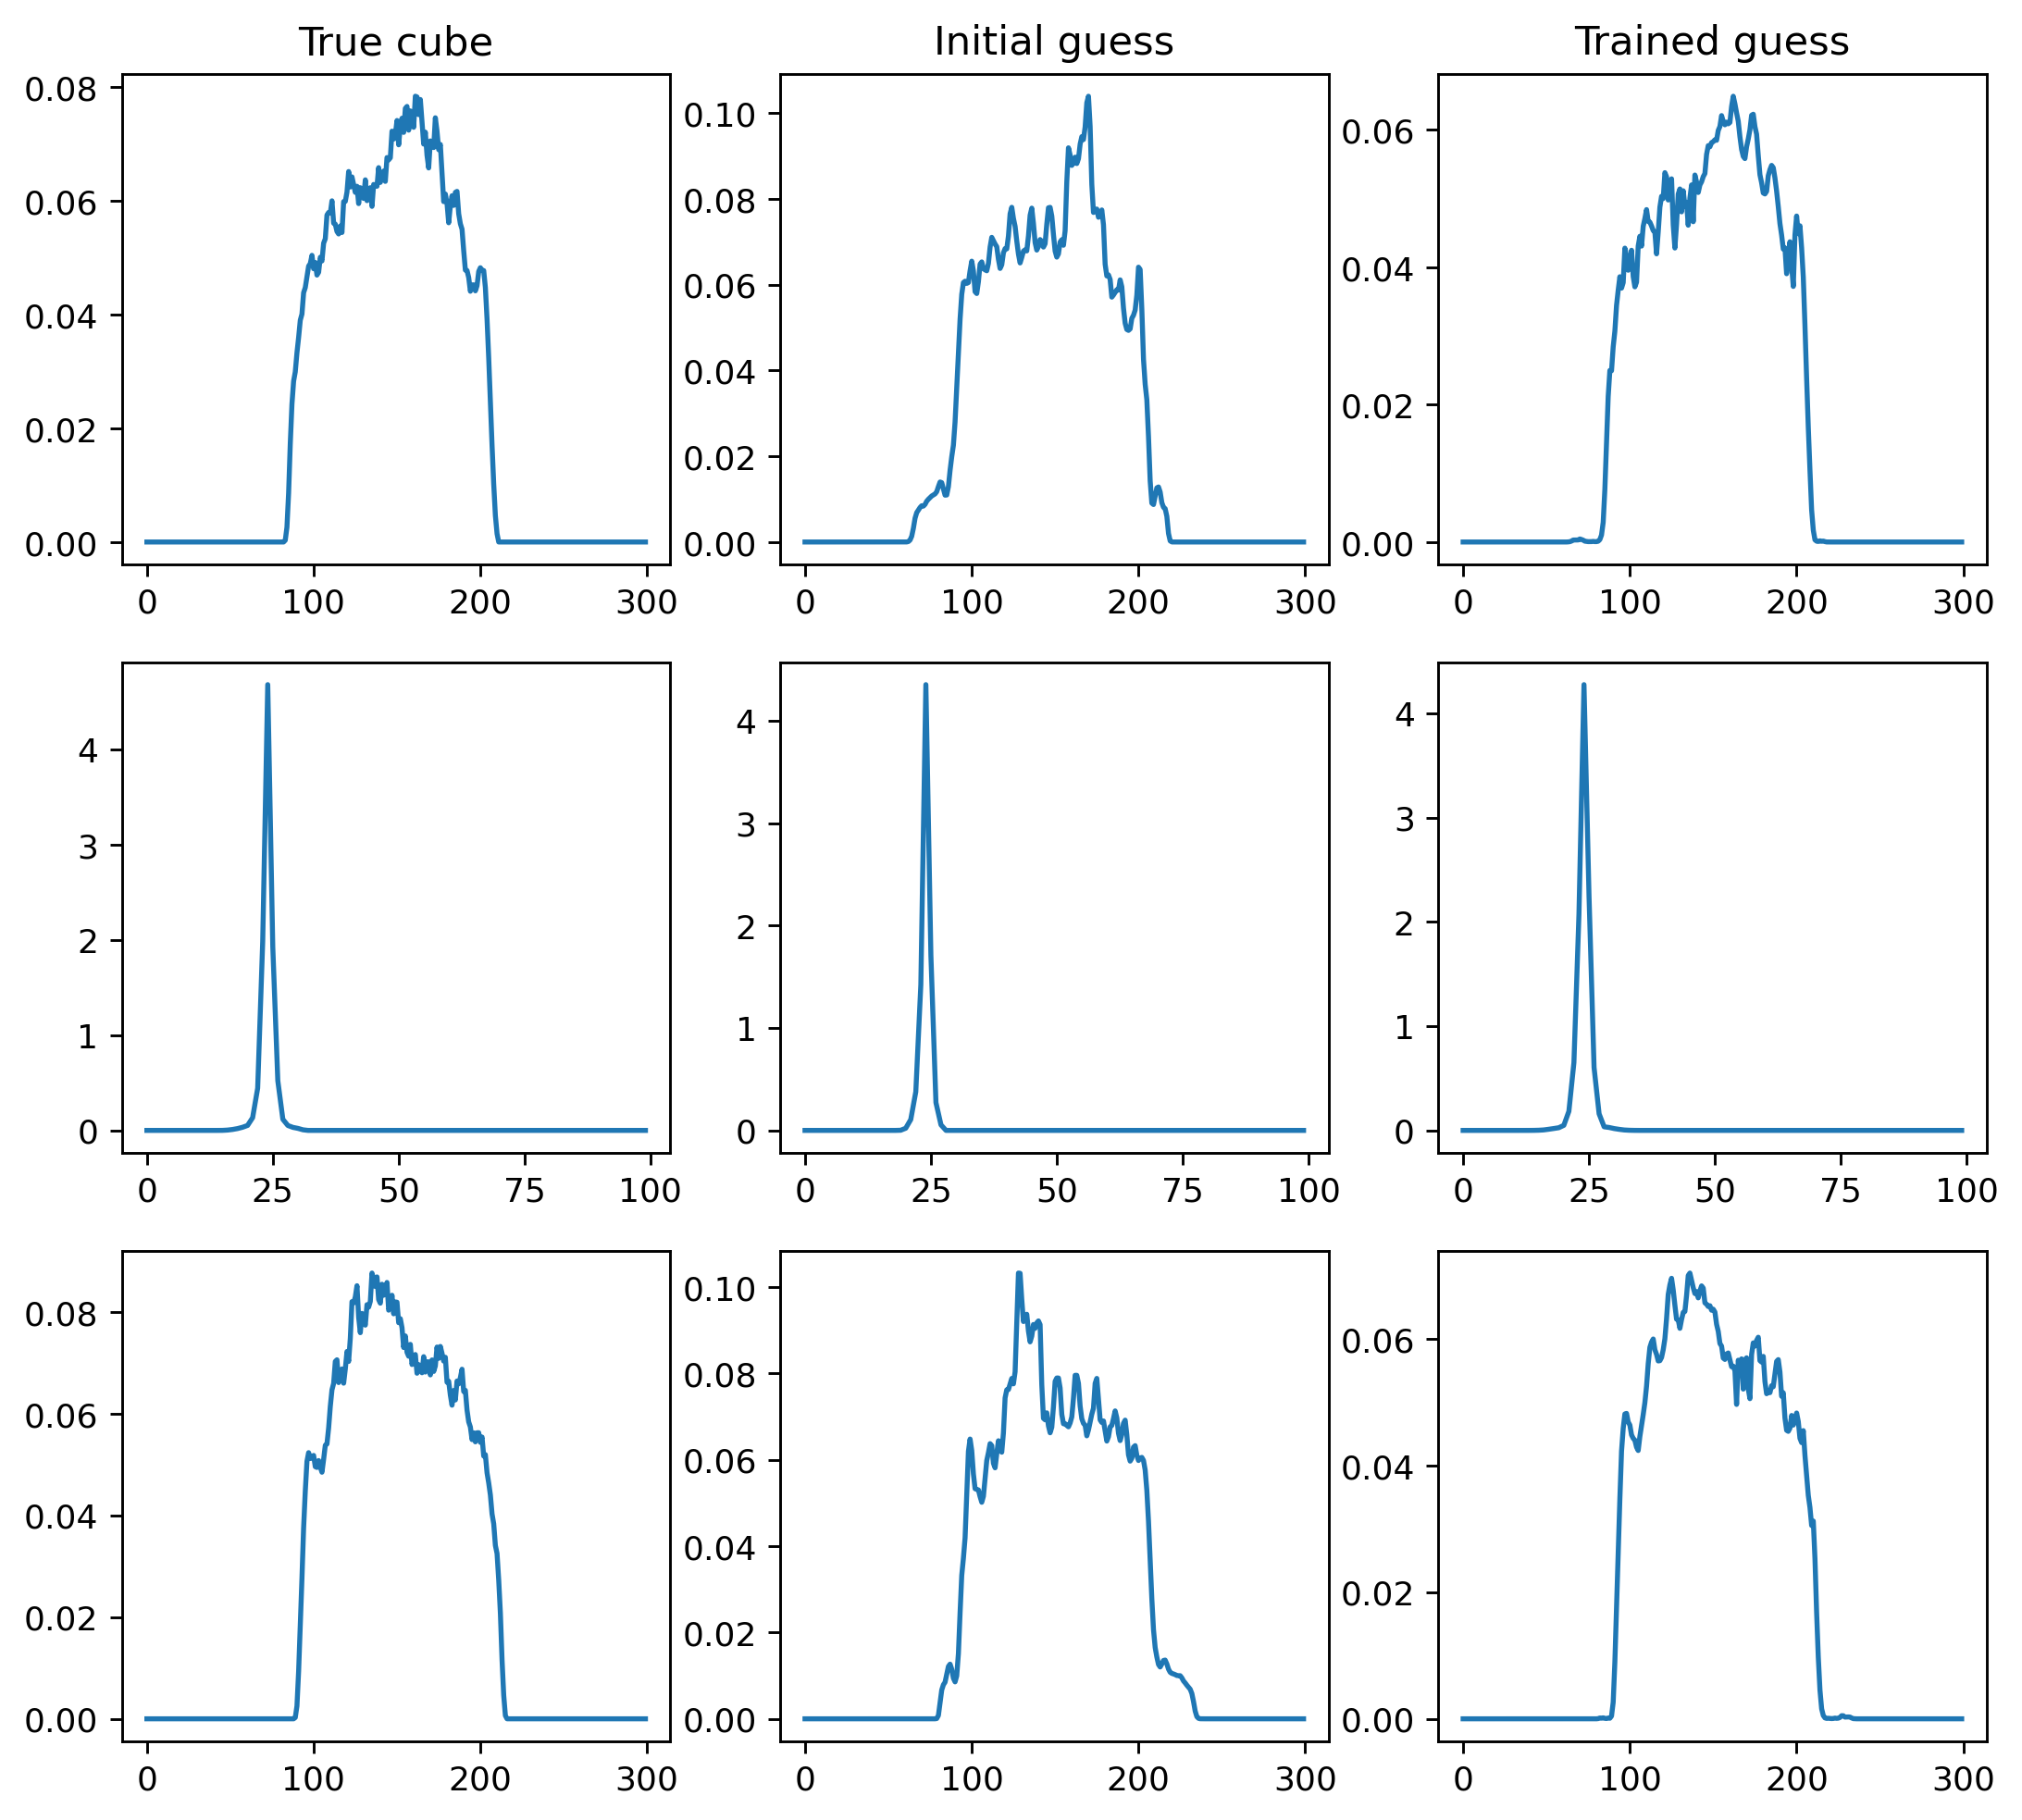

In [131]:
plot_orders = [0,1,2]

fig,ax = plt.subplots(len(plot_orders),3,figsize=(10,9),dpi=260)

for n,i in enumerate(plot_orders):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]#[200,400]
    
    vmax,vmin = torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).max(), torch.sum(grating_cube[0,:,b1:b2,b3:b4],dim=0).min()


    ax[n,0].plot(torch.sum(grating_cube[0,:,0,b3:b4],dim=0).cpu().detach().numpy()); ax[0,0].set_title('True cube')
    ax[n,1].plot(torch.sum(yhat_affine[0,:,0,b3:b4],dim=0).cpu().detach().numpy()); ax[0,1].set_title('Initial guess')
    ax[n,2].plot(torch.sum(yhat[0,:,0,b3:b4],dim=0).cpu().detach().numpy()); ax[0,2].set_title('Trained guess')



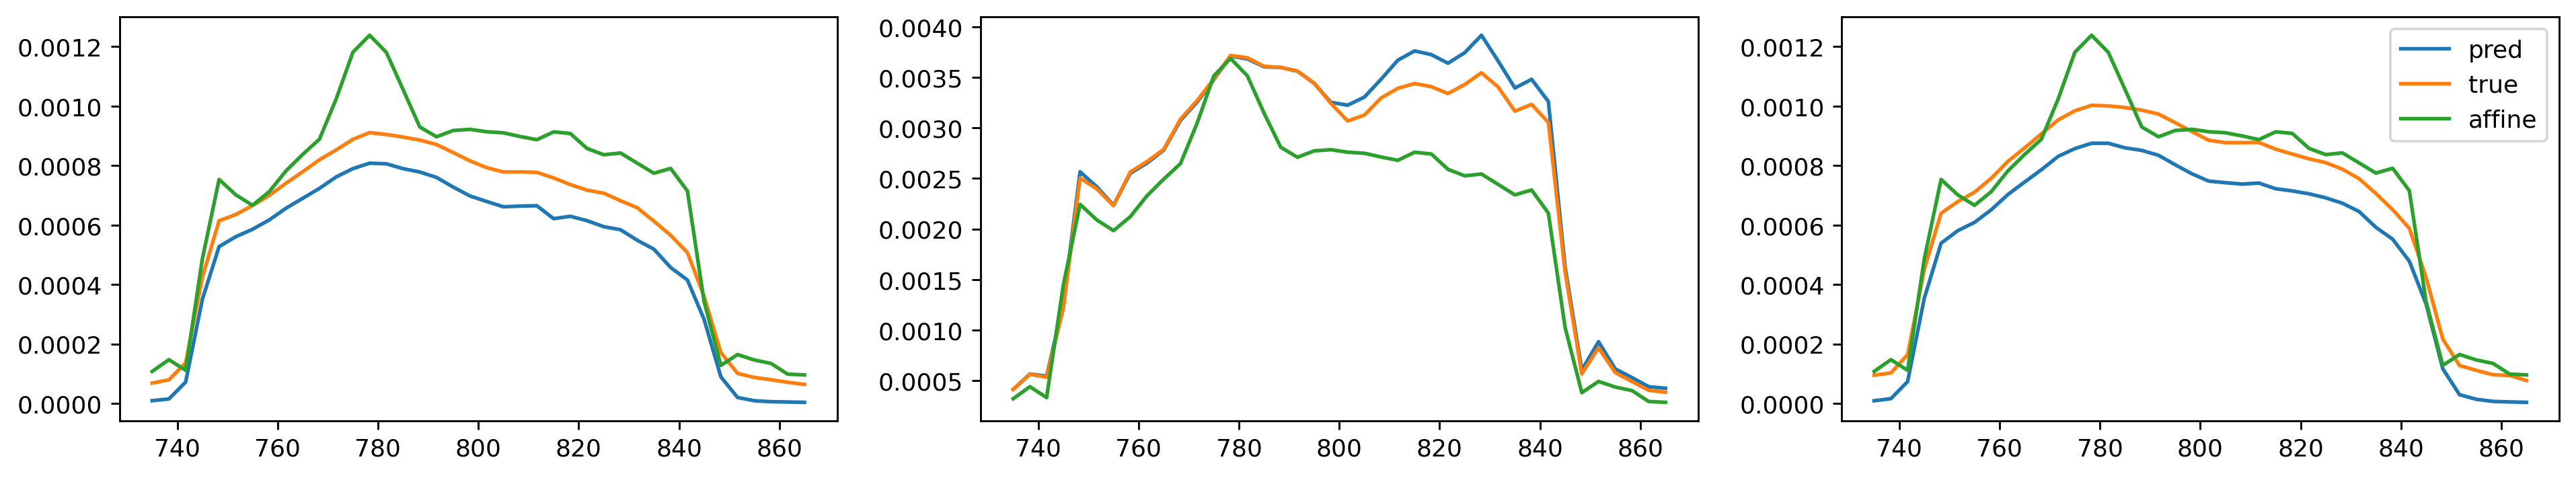

In [133]:
yhat = fwd.disperser.disperse_all_orders(nograting_cube,trained_kernel)

fig,ax = plt.subplots(1,cluster_points,figsize=(18,3),dpi=260)

for i in range(cluster_points):
    b1,b2 = pos[i,0]#[1600,1800]
    b3,b4 = pos[i,1]


    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),yhat[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T);
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),grating_cube[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T);
    ax[i].plot(np.linspace(desired_range[0],desired_range[1],desired_channels),yhat_affine[0,:,b1:b2,b3:b4].mean(dim=(2,1)).cpu().detach().numpy().T);
    plt.legend(['pred','true','affine'])

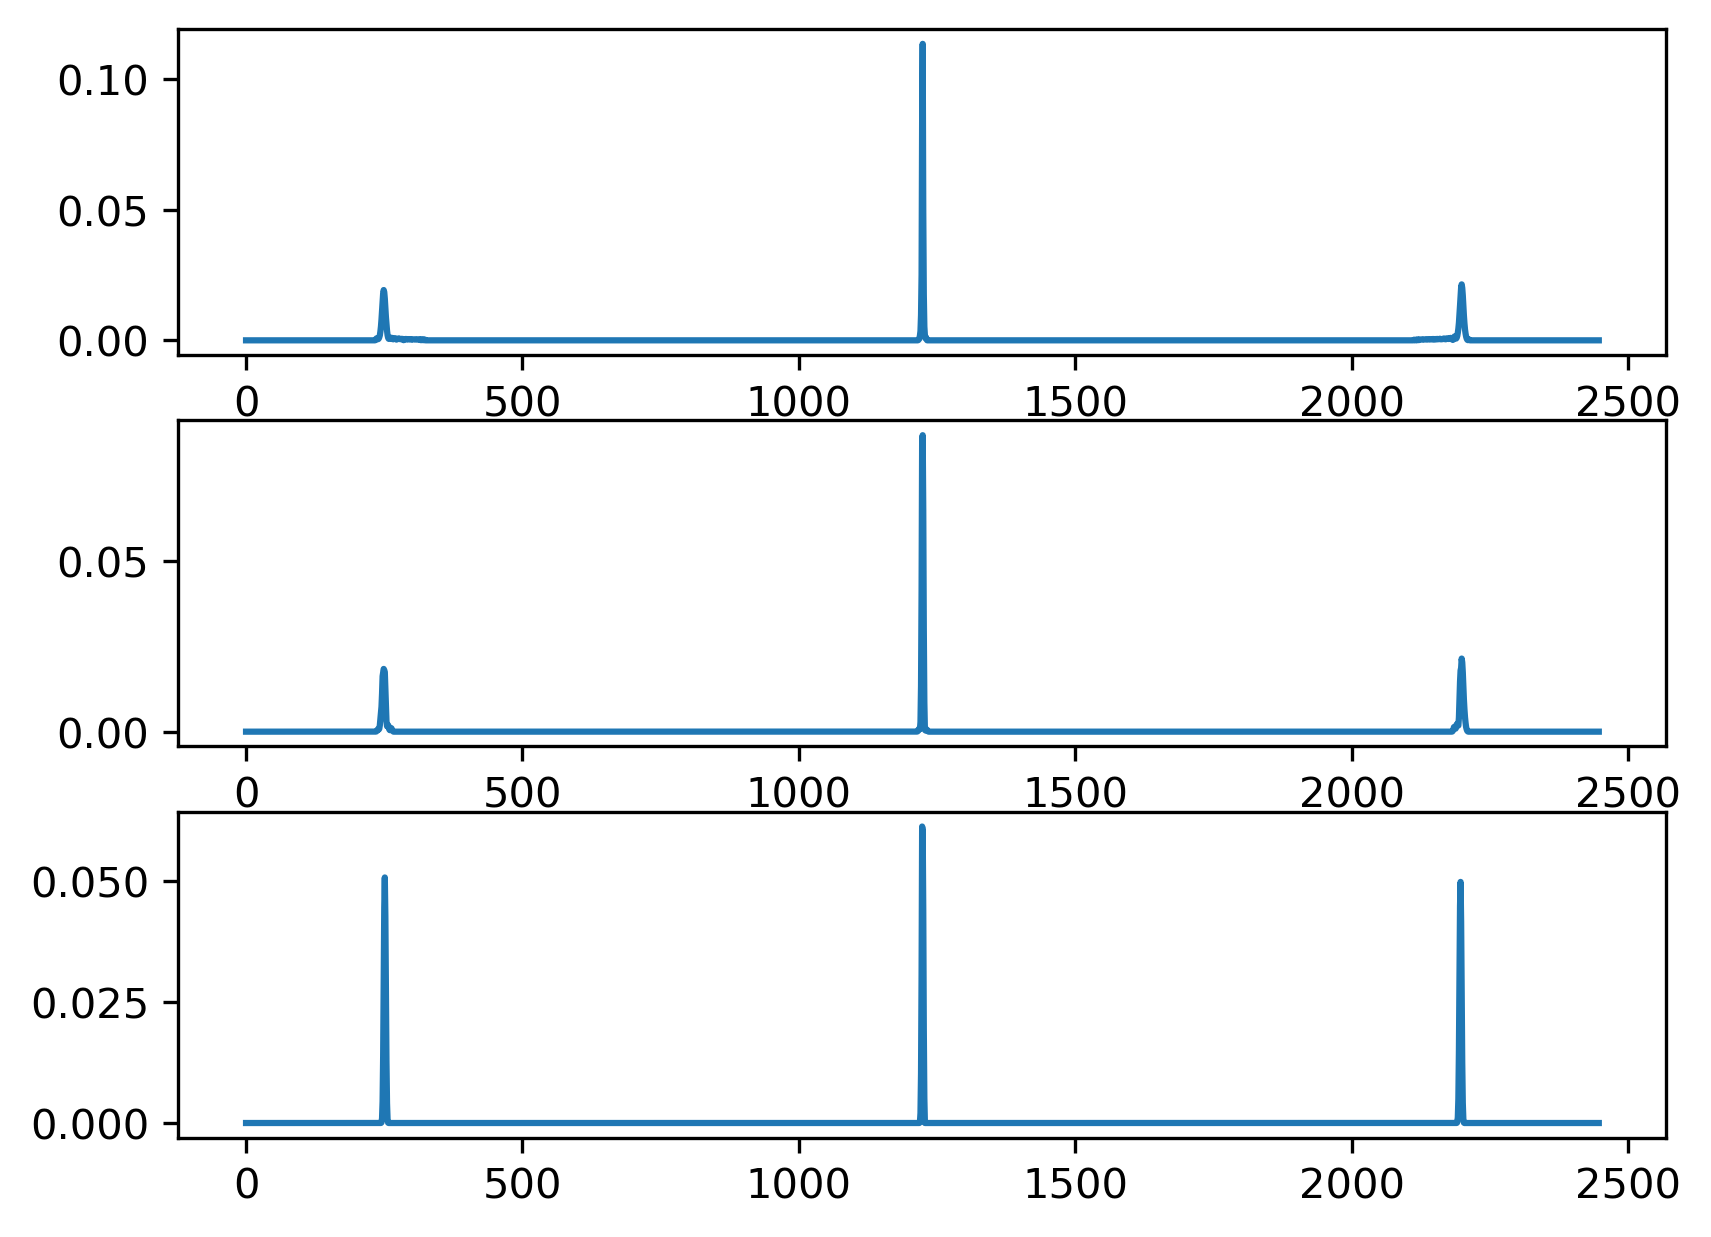

In [134]:
i = 30
wls = [i,i+1]
# wls = [6,8]


fig,ax = plt.subplots(3,1,dpi=300)
ax[0].plot(torch.abs(grating_cube[:,wls[0]:wls[1]].sum(dim=(0,1,2)).cpu().detach()), )
ax[1].plot(torch.abs(yhat[:,wls[0]:wls[1]].sum(dim=(0,1,2)).cpu().detach()),)
ax[2].plot(torch.abs(yhat_affine[:,wls[0]:wls[1]].sum(dim=(0,1,2)).cpu().detach()),)

In [135]:
torch.save(trained_kernel, '../kernel.pt')


### Now we have a kernel that should fit the data well. Lets see how well we can replicate a FTS measurement for the pinhole data by applying kernel to undispcube.

In [56]:
kernel = torch.load('../kernel.pt',map_location=device).requires_grad_(False)

_, spectras = hlp.create_bs_data(desired_channels=desired_channels, fts_dir = '20230925_1grating_pinhole_data_exptime_3500_us', desired_range=desired_range, device=device )

positions = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230925_1grating_pinhole_data_exptime_3500_us/positions.npy')

cutoff = [850,1200]

spectras = spectras[:,cutoff[0]:cutoff[1]]
positions = positions[cutoff[0]:cutoff[1]]  

dataset = hlp.FTSDataset(undispersed_cube=nograting_cube, spectra=spectras, positions=positions, dir = '20230925_1grating_pinhole_data_exptime_3500_us', angle = 0.28395252967192336)

indexes = [20,200]
(x,y) = dataset[indexes] 

synthetic_fts = fwd.calc_psi_z(torch.ones_like(y),y,{'kernel':kernel})
true_fts = torch.sum(x,dim=1).cpu()



collecting the undispersed cube and spectra.


In [63]:
synthetic_fts.shape

torch.Size([2, 1, 2448])

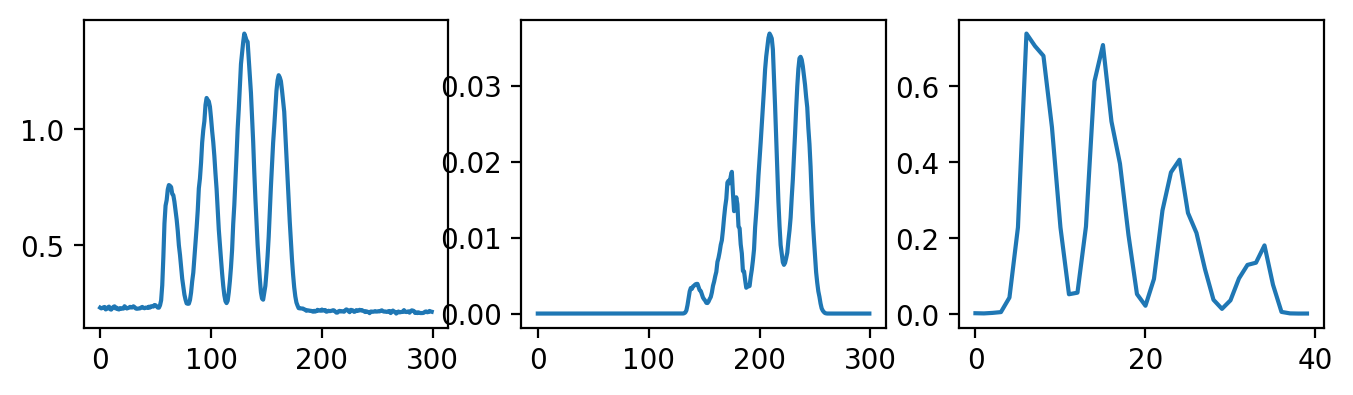

In [67]:
fig,ax = plt.subplots(1,3,figsize = (8,2),dpi=200)
ax[0].plot(true_fts[1,...,100:400])
ax[1].plot(synthetic_fts[1,0,100:400].cpu())
ax[2].plot(spectras[:,indexes[1]].cpu())



TypeError: can't convert cuda:2 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

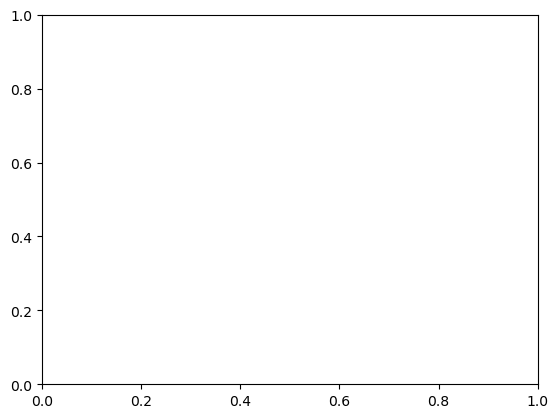

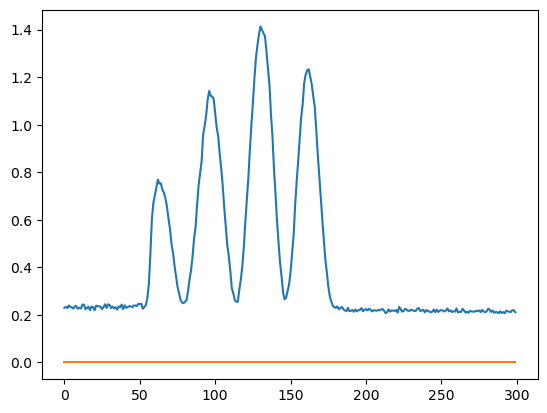

In [49]:
plt.plot()
plt.plot(torch.sum(synthetic_x[1,:,100:400],dim=0).cpu())

# plt.plot(spectras[:,200].cpu())

################## NORMALLY I HAVE TO RESET HERE TO AVOID OOM ###################### 
# The FTS measurements are scaled in another way. Apply this to kernel.

In [11]:
kernel = torch.load('../kernel.pt',map_location=device).requires_grad_(False)


In [13]:
kernel.sum()

tensor(27.7973, device='cuda:2')

In [14]:
bla = torch.zeros((1,desired_channels,500,2448))

bla[:,:,250:251] = kernel
kernel = bla.to(device)

At this point the kernel should be in the right position and the right shape. Lets check. Load the pinhole cube amd the grating cube

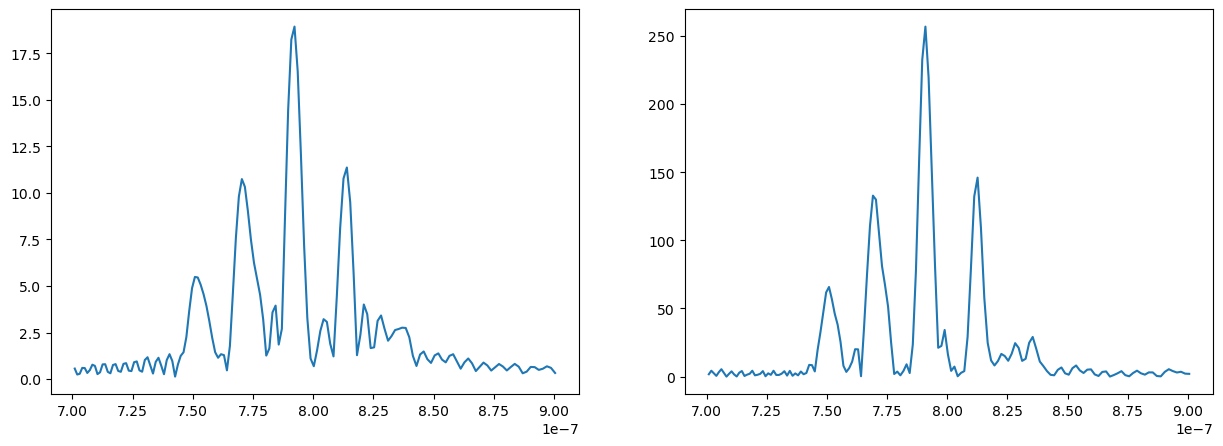

In [15]:
anadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230925_1grating_mask_analysis_exptime_1000_us/'
cube = np.load(anadir+'signalfft_padded_center_rotated_fixed_thresholded_new.npy')
freqs_mask = np.load(anadir+'freqs_padded_rotated_fixed_thresholded_new.npy')
wavls_mask = np.load(anadir+'wavls_padded_rotated_fixed_thresholded_new.npy')#*1e9

cube = hlp.normalize(cube, integration_time=1000)

sinc_deconv_kernel = np.load('../sincdeconvolutionkernel.npy')

sinc_deconv_kernel_mask = np.interp(freqs_mask, freqs, sinc_deconv_kernel)[np.newaxis,np.newaxis]



deconvolved_cube = WienerDeconvolution(cube, sinc_deconv_kernel_mask, lamb = 0.001)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(wavls_mask, cube[250,210])
ax[1].plot(wavls_mask, deconvolved_cube[250,210])

cube = downsample_signal(deconvolved_cube, desired_channels, initial_bins = wavls_mask, interp_axis = 2, desired_range = desired_range, interp_type='average') #interpolate to 750-850nm

grating_cube = torch.tensor(cube).permute(2,0,1).unsqueeze(0).to(device).to(torch.float32)

# 

In [16]:
# nograting_cube, _ = hlp.create_bs_data(desired_channels=50,desired_range=desired_range,fts_dir = '20230830_mask_data_talbot0_exptime_190_us', cube_dir ='20230830_mask_analysis_talbot0_exptime_190_us',  interp_type='average', device=device) #here we'll work with synthetic data. 
_ , spectras  = hlp.create_bs_data(desired_channels=desired_channels,desired_range=desired_range, fts_dir = '20230925_1grating_mask_data_exptime_1000_us',  interp_type='average', device=device) #here we'll work with synthetic data. 

grating_cube = grating_cube / grating_cube.max()

def threshold(cube):
    cube[cube<0.001*cube.max()] = 0
    return cube

# angle = 0.28395252967192336 #degrees from jannik

from skimage.transform import rotate
# grating_cube = torch.tensor(np.stack([rotate(grating_cube[0,i].cpu().numpy(),angle=angle) for i in range(grating_cube.shape[1])])).unsqueeze(0).to(device)

grating_cube = threshold(grating_cube)

print(grating_cube.mean())

undisp_cube = fwd.disperser.undisperse_all_orders(grating_cube,kernel,pad=.5, wiener=True, lamb=0.1)

energy = undisp_cube.mean()

decayer = torch.flip(torch.exp(-torch.linspace(0,10,1000)),dims=(0,)).to(device)
undisp_cube[...,:1000] *= decayer
decayer = torch.exp(-torch.linspace(0,10,undisp_cube.shape[-1]-1600)).to(device)
undisp_cube[...,1600:] *= decayer

undisp_cube = threshold(undisp_cube)

undisp_cube *= energy / undisp_cube.mean()

print(undisp_cube.mean())

grating_cuberecon = fwd.disperser.disperse_all_orders(undisp_cube,kernel,pad=.5)
# grating_cuberecon = threshold(grating_cuberecon)




collecting the undispersed cube and spectra.
tensor(0.0021, device='cuda:2')
tensor(0.0027, device='cuda:2')


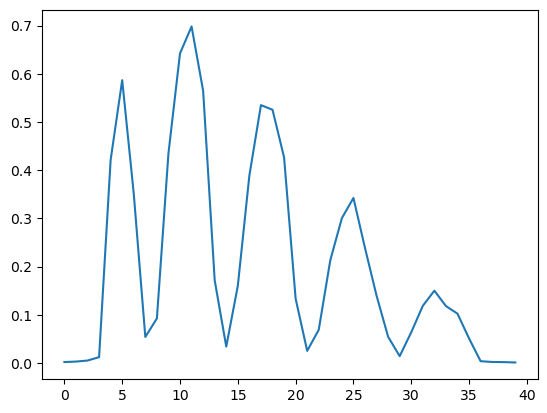

In [18]:
plt.plot(spectras[:,450].cpu())

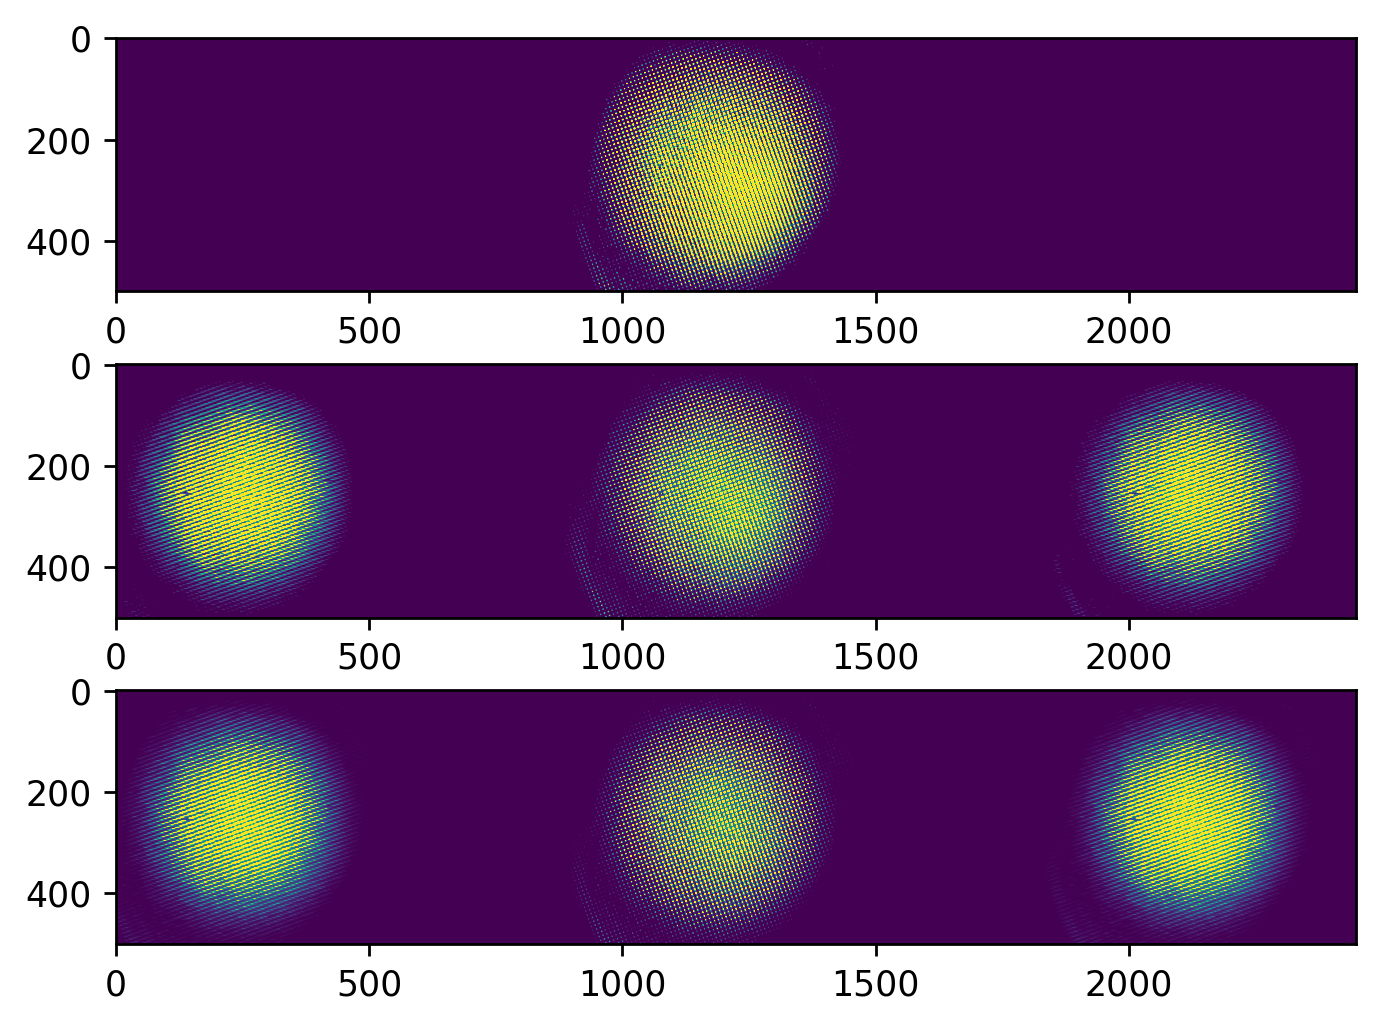

In [19]:
fig,ax = plt.subplots(3,1,dpi=250)
ax[0].imshow(undisp_cube[0,30].cpu().detach().numpy(), vmax=0.01 )
ax[1].imshow(grating_cube[0,20].cpu().detach().numpy(),vmax=0.01)
ax[2].imshow(grating_cuberecon[0,20].cpu().detach().numpy(), vmax=0.01)

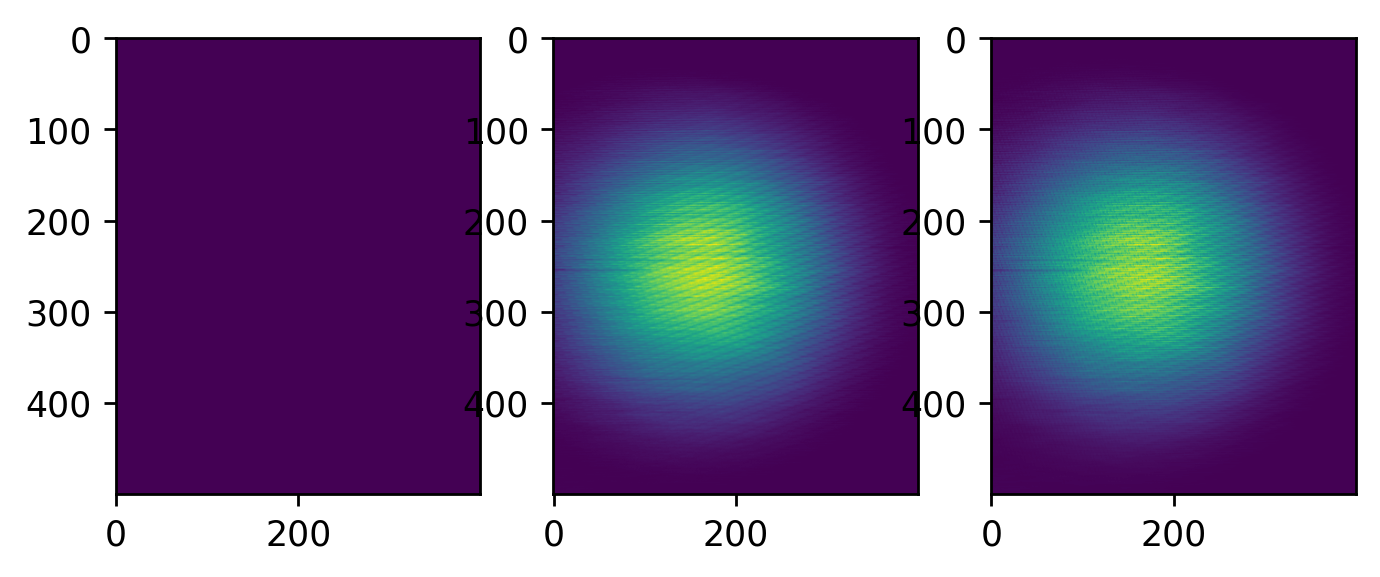

In [22]:
fig,ax = plt.subplots(1,3,dpi=250)
ax[0].imshow(undisp_cube.sum(dim=1)[0,:,100:500].cpu().detach().numpy())
ax[1].imshow(grating_cube.sum(dim=1)[0,:,100:500].cpu().detach().numpy())
ax[2].imshow(grating_cuberecon.sum(dim=1)[0,:,100:500].cpu().detach().numpy())

In [23]:
undisp_cube.mean(), grating_cube.mean(), grating_cuberecon.mean()


(tensor(0.0027, device='cuda:2'),
 tensor(0.0021, device='cuda:2'),
 tensor(0.0020, device='cuda:2'))

In [31]:
np.save('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230925_1grating_mask_analysis_exptime_1000_us/gtcube.npy',undisp_cube.cpu().detach().numpy())
np.save(anadir+'grating_cube.npy',grating_cube.cpu().detach().numpy())
torch.save(kernel, '../final_kernel.pt')


### Lets compare a FTS measurement to our simulated one...

In [32]:
spectras.shape

torch.Size([40, 1499])

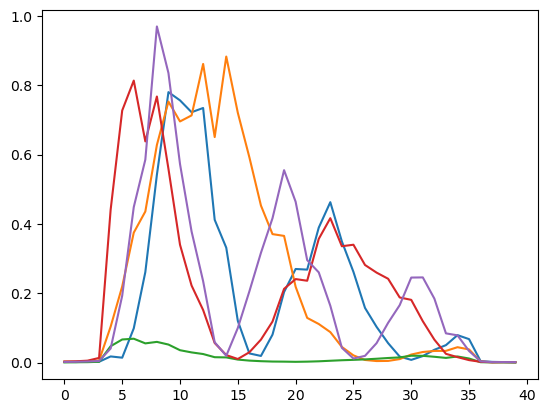

In [42]:
plt.figure()
for i in range(600,1100,100):
    plt.plot(spectras[:,i].cpu())


In [47]:
mod_cube = undisp_cube*spectras[:,800].unsqueeze(1).unsqueeze(2).unsqueeze(3)

fwd.calc_psi_z(torch.ones_like(mod_cube),mod_cube,{'kernel':kernel})

RuntimeError: CUDA out of memory. Tried to allocate 1.46 GiB (GPU 2; 44.56 GiB total capacity; 42.55 GiB already allocated; 1.12 GiB free; 42.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF